In [5]:
# YouTube Southeast Asian Food Travel Content - Data Analysis and Modeling
# This notebook performs data cleaning, feature engineering, and predictive modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import re
import json

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")




# 1: Data Loading and Initial Exploration

In [7]:
# Load the collected dataset
try:
    df = pd.read_csv('data/youtube_sea_food_travel_data.csv')
    print(f"✅ Successfully loaded dataset with {len(df)} videos and {len(df.columns)} columns")
    
    # Display basic information
    print(f"\nDataset Info:")
    print(f"- Date range: {df['published_at'].min()} to {df['published_at'].max()}")
    print(f"- Unique channels: {df['channel_id'].nunique()}")
    print(f"- Videos with comments: {(df['comments_count_collected'] > 0).sum()}")
    print(f"- Trending videos: {df['is_trending'].sum()}")
    
except FileNotFoundError:
    print("❌ Error: 'youtube_sea_food_travel_data.csv' not found in 'data/' directory")
    print("Please run the data collection notebook first!")
    raise

# Display first few rows
print(f"\n📋 Sample Data (first 3 rows):")
print(df[['title', 'channel_title', 'view_count', 'like_count', 'is_trending']].head(3))



✅ Successfully loaded dataset with 1466 videos and 29 columns

Dataset Info:
- Date range: 2023-08-04 17:00:24+00:00 to 2025-08-02 15:00:05+00:00
- Unique channels: 935
- Videos with comments: 1304
- Trending videos: 25

📋 Sample Data (first 3 rows):
                                               title  channel_title  \
0         Thai Street Food Ramkhamhaeng Night Market  DancingBacons   
1  Incredible Top 10 Most Popular Thai Foods || T...        OnAir24   
2              Thai Street Food Chillva Night Market  DancingBacons   

   view_count  like_count  is_trending  
0      789598       11147        False  
1      172476        2198        False  
2     1987111       21067        False  


# 2: Data Quality Assessment

In [9]:
# Check for missing values
print("Missing Values Analysis:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_summary[missing_summary['Missing Count'] > 0])

# Data types overview
print(f"\nData Types:")
print(df.dtypes.value_counts())

# Basic statistics for numerical columns
print(f"\nNumerical Columns Statistics:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
print(df[numerical_cols].describe())


Missing Values Analysis:
               Missing Count  Missing Percentage
comments_text            162           11.050477
description               36            2.455662

Data Types:
int64      13
object     11
float64     4
bool        1
Name: count, dtype: int64

Numerical Columns Statistics:
       category_id    view_count     like_count  comment_count  \
count  1466.000000  1.466000e+03    1466.000000    1466.000000   
mean     22.145975  2.302613e+05    4171.071623     261.361528   
std       2.735778  8.591552e+05   18167.843895    1064.451054   
min       1.000000  2.000000e+00       0.000000       0.000000   
25%      19.000000  1.952750e+03      39.000000       6.000000   
50%      22.000000  1.943650e+04     362.000000      41.000000   
75%      24.000000  1.257988e+05    2197.750000     160.000000   
max      29.000000  1.288148e+07  382982.000000   19216.000000   

       duration_seconds  comments_count_collected  comments_total_likes  \
count       1466.000000         

# 3: Data Cleaning 

In [11]:

# Create a copy for cleaning
df_clean = df.copy()
initial_rows = len(df_clean)

# Clean published_at column
df_clean['published_at'] = pd.to_datetime(df_clean['published_at'])

# Handle missing tags (convert to empty list)
df_clean['tags'] = df_clean['tags'].fillna('[]')
# Safely evaluate string representation of lists
def safe_eval_tags(tag_str):
    try:
        if pd.isna(tag_str) or tag_str == '[]' or tag_str == '':
            return []
        # Handle string representation of lists
        if isinstance(tag_str, str):
            # Clean the string and evaluate
            cleaned = tag_str.strip()
            if cleaned.startswith('[') and cleaned.endswith(']'):
                return eval(cleaned)
            else:
                return [cleaned]  # Single tag as string
        return tag_str if isinstance(tag_str, list) else []
    except:
        return []

df_clean['tags'] = df_clean['tags'].apply(safe_eval_tags)

# Handle missing descriptions
df_clean['description'] = df_clean['description'].fillna('')

# Handle missing comments
df_clean['comments_text'] = df_clean['comments_text'].fillna('')

# Remove videos with zero views (likely errors or private videos)
df_clean = df_clean[df_clean['view_count'] > 0]

# Remove extremely short videos (likely trailers or errors)
df_clean = df_clean[df_clean['duration_seconds'] >= 30]

# Remove videos with suspicious engagement (potential bots)
# Flag videos with like ratios that are too high (>50% likes per view)
df_clean = df_clean[df_clean['like_to_view_ratio'] <= 0.5]

print(f"Data Cleaning Results:")
print(f"- Rows before cleaning: {initial_rows}")
print(f"- Rows after cleaning: {len(df_clean)}")
print(f"- Rows removed: {initial_rows - len(df_clean)} ({((initial_rows - len(df_clean))/initial_rows)*100:.1f}%)")

Data Cleaning Results:
- Rows before cleaning: 1466
- Rows after cleaning: 1466
- Rows removed: 0 (0.0%)


# 4: Exploratory Data Analysis

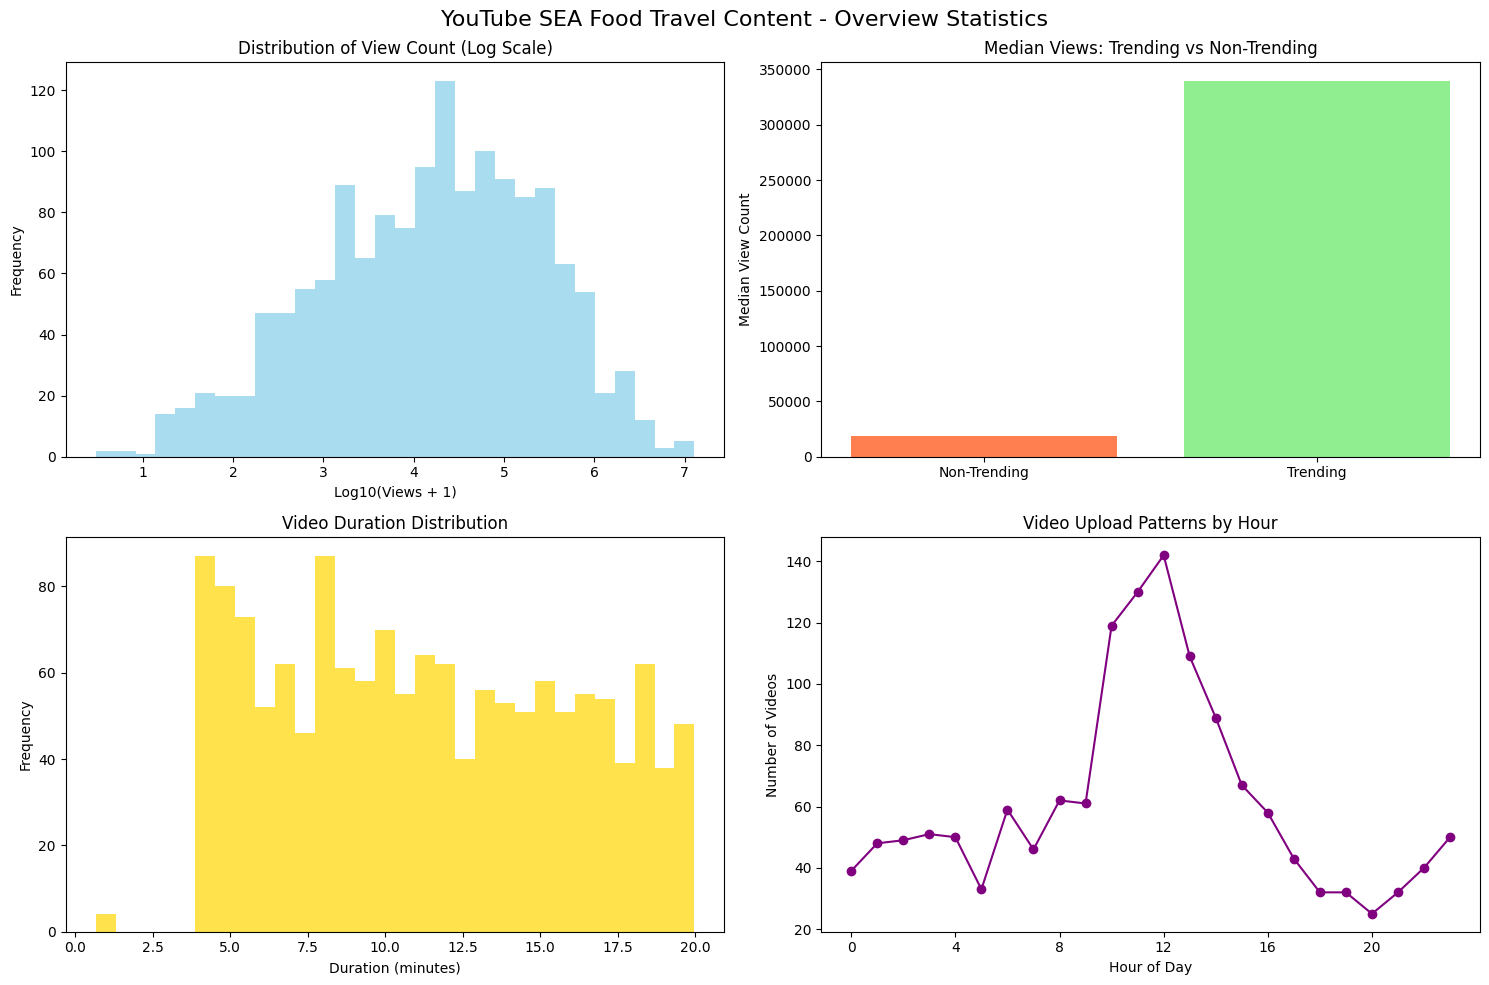


Top 10 Channels by Video Count:
channel_title
Ice Tea Jay                        15
Grif's Food and Travel             15
Pailin's Kitchen                   14
Vietnam Street Food                13
Hungry Fish Eye                    13
So Yummie                          11
Bec & Matt Adventures              11
HappyCat.黑皮猫                       10
More Best Ever Food Review Show    10
Ted Aroi                           10
Name: count, dtype: int64

Top 10 Channels by Average Views:
channel_title
Luisito Comunica                   12881482.0
tzuyang쯔양                          11194019.0
MR. INDIAN HACKER                   9018150.0
Kusina ni Lola                      6405022.0
Nomadic Chandan                     6231006.0
Yummy Go 야미고                        5842554.0
mrnigelng                           3811759.0
Food Stories                        3147043.0
Toni Gonzaga Studio                 3027050.0
More Best Ever Food Review Show     3004177.0
Name: view_count, dtype: float64

Cont

In [13]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('YouTube SEA Food Travel Content - Overview Statistics', fontsize=16)

# 1. View count distribution
axes[0,0].hist(np.log10(df_clean['view_count'] + 1), bins=30, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of View Count (Log Scale)')
axes[0,0].set_xlabel('Log10(Views + 1)')
axes[0,0].set_ylabel('Frequency')

# 2. Trending vs Non-trending comparison
trending_data = df_clean.groupby('is_trending')['view_count'].median().reset_index()
axes[0,1].bar(['Non-Trending', 'Trending'], trending_data['view_count'], color=['coral', 'lightgreen'])
axes[0,1].set_title('Median Views: Trending vs Non-Trending')
axes[0,1].set_ylabel('Median View Count')

# 3. Video duration distribution
axes[1,0].hist(df_clean['duration_seconds']/60, bins=30, alpha=0.7, color='gold')
axes[1,0].set_title('Video Duration Distribution')
axes[1,0].set_xlabel('Duration (minutes)')
axes[1,0].set_ylabel('Frequency')

# 4. Upload time patterns
hour_counts = df_clean['publish_hour'].value_counts().sort_index()
axes[1,1].plot(hour_counts.index, hour_counts.values, marker='o', color='purple')
axes[1,1].set_title('Video Upload Patterns by Hour')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Number of Videos')
axes[1,1].set_xticks(range(0, 24, 4))

plt.tight_layout()
plt.show()

# Channel analysis
print(f"\nTop 10 Channels by Video Count:")
top_channels = df_clean['channel_title'].value_counts().head(10)
print(top_channels)

print(f"\nTop 10 Channels by Average Views:")
channel_avg_views = df_clean.groupby('channel_title')['view_count'].mean().sort_values(ascending=False).head(10)
print(channel_avg_views.round(0))

# Content analysis by country/cuisine
print(f"\nContent Distribution by Country/Cuisine:")
countries = ['thai', 'vietnam', 'malaysia', 'singapore', 'indonesia', 'filipino', 'myanmar', 'cambodia']
country_counts = {}
for country in countries:
    count = df_clean['title'].str.lower().str.contains(country, na=False).sum()
    if count > 0:
        country_counts[country.capitalize()] = count

for country, count in sorted(country_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(df_clean)) * 100
    print(f"- {country}: {count} videos ({percentage:.1f}%)")

# Engagement analysis
print(f"\nEngagement Statistics:")
print(f"- Average engagement score: {df_clean['engagement_score'].mean():.6f}")
print(f"- Median like-to-view ratio: {df_clean['like_to_view_ratio'].median():.6f}")
print(f"- Median comment-to-view ratio: {df_clean['comment_to_view_ratio'].median():.6f}")

# Trending analysis
trending_stats = df_clean.groupby('is_trending').agg({
    'view_count': ['mean', 'median'],
    'like_count': ['mean', 'median'],
    'comment_count': ['mean', 'median'],
    'engagement_score': ['mean', 'median']
}).round(2)

print(f"\nTrending vs Non-Trending Comparison:")
print(trending_stats)



In [14]:
df_clean.head()

,video_id,title,description,channel_title,channel_id,published_at,tags,category_id,view_count,like_count,...,publish_day_of_week,publish_month,like_to_view_ratio,comment_to_view_ratio,engagement_score,duration_category,title_length,description_length,tags_count,is_trending
0,syl5ZHuW8ws,Thai Street Food Ramkhamhaeng Night Market,Ramkhamhaeng is a large local night market whe...,DancingBacons,UCRFj4Yj1nKhgrT-_8AUsaDg,2024-05-11 19:46:46+00:00,"[thailand, bangkok, halal, ramkhamhaeng, night...",19,789598,11147,...,5,5,0.014117,0.000414,0.014531,Long,42,458,16,False
1,P8G7T4Trx34,Incredible Top 10 Most Popular Thai Foods || T...,Incredible Top 10 Most Popular Thai Foods || M...,OnAir24,UCDxAQEKKCeBcYwx0HhWUJ5w,2023-09-14 19:34:44+00:00,"[Top 10 Most Popular Thai Foods, Thai Street F...",27,172476,2198,...,3,9,0.012744,0.000452,0.013196,Medium,95,1843,23,False
2,j_GurQPMMeA,Thai Street Food Chillva Night Market,A large Night Market in Phuket Thailand where ...,DancingBacons,UCRFj4Yj1nKhgrT-_8AUsaDg,2024-01-18 00:02:50+00:00,"[street food, night market, thailand, phuket, ...",19,1987111,21067,...,3,1,0.010602,0.000256,0.010858,Long,37,400,20,False
3,cLEixT0b0MM,Fear Factor Street Food in Bangkok Thailand,Eating 7 exotic street food in Thailand that a...,DancingBacons,UCRFj4Yj1nKhgrT-_8AUsaDg,2024-05-05 00:48:52+00:00,"[Street food, thai, thailand, asia, insects, s...",19,446611,9820,...,6,5,0.021988,0.001527,0.023515,Medium,43,204,13,False
4,zgYjuWxhY-o,10 Minutes in Bangkok - A Typical Thai Street ...,Dive headfirst into the vibrant and chaotic wo...,bangkokandmore,UCBoJoDMyQAtLkS6ARPhJagg,2024-11-10 01:48:13+00:00,"[Bangkok, Thailand, street food, Thai food, Pa...",19,24365,0,...,6,11,0.000000,0.000205,0.000205,Long,57,1241,23,False


# 5: Feature Engineering

In [16]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [17]:
# Import additional libraries for feature engineering
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import string

# Download required NLTK data
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Initialize text processing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [18]:
def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    
    Args:
        text (str): Raw text to process
        
    Returns:
        str: Cleaned and preprocessed text
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters and numbers (keep letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and short words
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    # Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join back to string
    return ' '.join(tokens)


# 5.1 Text Preprocessing

In [20]:
# Apply text preprocessing
print("Processing titles...")
df_clean['title_processed'] = df_clean['title'].apply(preprocess_text)

print("Processing descriptions...")
df_clean['description_processed'] = df_clean['description'].apply(preprocess_text)

print("Processing comments...")
df_clean['comments_processed'] = df_clean['comments_text'].apply(preprocess_text)

# Combine all text for comprehensive topic modeling
df_clean['combined_text'] = (
    df_clean['title_processed'] + ' ' + 
    df_clean['description_processed'] + ' ' + 
    df_clean['comments_processed']
).str.strip()

Processing titles...
Processing descriptions...
Processing comments...


# 5.2 Advanced Temporal Features

In [22]:
# Extract more detailed time features
df_clean['publish_year'] = df_clean['published_at'].dt.year
df_clean['publish_quarter'] = df_clean['published_at'].dt.quarter
df_clean['publish_week'] = df_clean['published_at'].dt.isocalendar().week
df_clean['is_weekend'] = df_clean['publish_day_of_week'].isin([5, 6]).astype(int)

# Time since publication (days)
# Handle timezone compatibility
current_time = pd.Timestamp.now(tz='UTC')
df_clean['days_since_publication'] = (
    current_time - df_clean['published_at']
).dt.days

# Optimal posting time categories
def categorize_posting_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df_clean['posting_time_category'] = df_clean['publish_hour'].apply(categorize_posting_time)

# 5.3 Content Features

In [24]:
# Video title analysis
df_clean['title_word_count'] = df_clean['title_processed'].str.split().str.len()
df_clean['title_char_count'] = df_clean['title'].str.len()
df_clean['title_has_question'] = df_clean['title'].str.contains(r'\?', na=False).astype(int)
df_clean['title_has_exclamation'] = df_clean['title'].str.contains(r'!', na=False).astype(int)
df_clean['title_all_caps_words'] = df_clean['title'].str.count(r'\b[A-Z]{2,}\b')

# Description analysis
df_clean['description_word_count'] = df_clean['description_processed'].str.split().str.len()
df_clean['description_char_count'] = df_clean['description'].str.len()
df_clean['description_has_links'] = df_clean['description'].str.contains(r'http|www', na=False).astype(int)

# Tags analysis
df_clean['tags_count_actual'] = df_clean['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['avg_tag_length'] = df_clean['tags'].apply(
    lambda x: np.mean([len(tag) for tag in x]) if isinstance(x, list) and len(x) > 0 else 0
)

# 5.4 Engagement Features

In [26]:
# Advanced engagement metrics
df_clean['likes_per_day'] = df_clean['like_count'] / (df_clean['days_since_publication'] + 1)
df_clean['views_per_day'] = df_clean['view_count'] / (df_clean['days_since_publication'] + 1)
df_clean['comments_per_day'] = df_clean['comment_count'] / (df_clean['days_since_publication'] + 1)

# Engagement velocity (early vs sustained engagement)
df_clean['early_engagement_indicator'] = (
    df_clean['engagement_score'] > df_clean['engagement_score'].median()
).astype(int)

# Comment engagement ratio
df_clean['comment_likes_ratio'] = df_clean['comments_total_likes'] / (df_clean['comments_count_collected'] + 1)

# 5.5 Content Category Features

In [28]:
# Cuisine type detection from titles and descriptions
cuisine_keywords = {
    'thai': ['thai', 'thailand', 'bangkok', 'pad thai', 'tom yum', 'curry'],
    'vietnamese': ['vietnam', 'vietnamese', 'pho', 'saigon', 'hanoi', 'banh mi'],
    'malaysian': ['malaysia', 'malaysian', 'kuala lumpur', 'penang', 'nasi lemak'],
    'singaporean': ['singapore', 'singaporean', 'hainanese'],
    'indonesian': ['indonesia', 'indonesian', 'jakarta', 'bali', 'nasi goreng'],
    'filipino': ['philippines', 'filipino', 'manila', 'adobo']
}

def detect_cuisine_types(text):
    """Detect multiple cuisine types in text"""
    text_lower = str(text).lower()
    detected = []
    for cuisine, keywords in cuisine_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            detected.append(cuisine)
    return detected

# Apply cuisine detection
df_clean['detected_cuisines'] = (
    df_clean['title'] + ' ' + df_clean['description']
).apply(detect_cuisine_types)

df_clean['cuisine_count'] = df_clean['detected_cuisines'].apply(len)
df_clean['is_multi_cuisine'] = (df_clean['cuisine_count'] > 1).astype(int)

# Create individual cuisine flags
for cuisine in cuisine_keywords.keys():
    df_clean[f'is_{cuisine}'] = df_clean['detected_cuisines'].apply(
        lambda x: 1 if cuisine in x else 0
    )

# Content type detection
content_types = {
    'street_food': ['street food', 'hawker', 'market', 'vendor'],
    'restaurant': ['restaurant', 'dining', 'fine dining', 'cafe'],
    'cooking': ['cooking', 'recipe', 'how to make', 'kitchen'],
    'travel': ['travel', 'trip', 'visit', 'tour', 'explore', 'guide'],
    'review': ['review', 'taste test', 'trying', 'rating']
}

def detect_content_types(text):
    """Detect content types in text"""
    text_lower = str(text).lower()
    detected = []
    for content_type, keywords in content_types.items():
        if any(keyword in text_lower for keyword in keywords):
            detected.append(content_type)
    return detected

df_clean['detected_content_types'] = (
    df_clean['title'] + ' ' + df_clean['description']
).apply(detect_content_types)

# Create individual content type flags
for content_type in content_types.keys():
    df_clean[f'is_{content_type}'] = df_clean['detected_content_types'].apply(
        lambda x: 1 if content_type in x else 0
    )


# 5.6 Channel Performance Features

In [30]:
# Channel-level aggregated features
channel_stats = df_clean.groupby('channel_id').agg({
    'view_count': ['mean', 'std', 'count'],
    'like_count': 'mean',
    'engagement_score': 'mean',
    'is_trending': 'mean'
}).round(4)

# Flatten column names
channel_stats.columns = ['_'.join(col).strip() for col in channel_stats.columns]
channel_stats = channel_stats.add_prefix('channel_')

# Merge back to main dataframe
df_clean = df_clean.merge(channel_stats, left_on='channel_id', right_index=True, how='left')

# 5.7 Relative Performance Features

In [32]:
# Performance relative to channel average
df_clean['views_vs_channel_avg'] = (
    df_clean['view_count'] / df_clean['channel_view_count_mean']
)
df_clean['likes_vs_channel_avg'] = (
    df_clean['like_count'] / df_clean['channel_like_count_mean']
)
df_clean['engagement_vs_channel_avg'] = (
    df_clean['engagement_score'] / df_clean['channel_engagement_score_mean']
)

# Video performance percentile within channel
df_clean['channel_performance_percentile'] = df_clean.groupby('channel_id')['view_count'].rank(pct=True)


# 5.8 Duration and Quality Features

In [34]:
# Duration analysis
df_clean['duration_minutes'] = df_clean['duration_seconds'] / 60

# Duration categories (more granular)
def categorize_duration(seconds):
    minutes = seconds / 60
    if minutes < 3:
        return 'Very Short'
    elif minutes < 8:
        return 'Short'
    elif minutes < 15:
        return 'Medium'
    elif minutes < 25:
        return 'Long'
    else:
        return 'Very Long'

df_clean['duration_category_detailed'] = df_clean['duration_seconds'].apply(categorize_duration)

# Content quality indicators
df_clean['has_thumbnail'] = (df_clean['thumbnail_url'] != '').astype(int)
df_clean['title_description_ratio'] = df_clean['title_length'] / (df_clean['description_length'] + 1)


# 5.9 Encoding Categorical Variables

In [36]:
# Label encode categorical variables for modeling
categorical_columns = [
    'posting_time_category', 
    'duration_category_detailed',
    'publish_day_of_week',
    'publish_month',
    'publish_quarter'
]

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

print("✅ Feature Engineering Summary:")
print("-" * 30)
print(f"Original features: {len(df.columns)}")
print(f"Features after engineering: {len(df_clean.columns)}")
print(f"New features created: {len(df_clean.columns) - len(df.columns)}")

# Show new feature categories
new_features = [col for col in df_clean.columns if col not in df.columns]
feature_categories = {
    'Text Processing': [f for f in new_features if 'processed' in f or 'combined' in f],
    'Temporal': [f for f in new_features if any(x in f for x in ['publish', 'days_since', 'weekend', 'time_category'])],
    'Content Analysis': [f for f in new_features if any(x in f for x in ['title_', 'description_', 'cuisine', 'content_type'])],
    'Engagement': [f for f in new_features if any(x in f for x in ['per_day', 'ratio', 'engagement', 'likes_'])],
    'Channel': [f for f in new_features if 'channel_' in f],
    'Encoding': [f for f in new_features if '_encoded' in f]
}

for category, features in feature_categories.items():
    if features:
        print(f"\n{category} Features ({len(features)}):")
        for feature in features[:5]:  # Show first 5 features
            print(f"  - {feature}")
        if len(features) > 5:
            print(f"  ... and {len(features) - 5} more")



✅ Feature Engineering Summary:
------------------------------
Original features: 29
Features after engineering: 88
New features created: 59

Text Processing Features (4):
  - title_processed
  - description_processed
  - comments_processed
  - combined_text

Temporal Features (10):
  - publish_year
  - publish_quarter
  - publish_week
  - is_weekend
  - days_since_publication
  ... and 5 more

Content Analysis Features (15):
  - title_processed
  - description_processed
  - title_word_count
  - title_char_count
  - title_has_question
  ... and 10 more

Engagement Features (12):
  - likes_per_day
  - views_per_day
  - comments_per_day
  - early_engagement_indicator
  - comment_likes_ratio
  ... and 7 more

Channel Features (10):
  - channel_view_count_mean
  - channel_view_count_std
  - channel_view_count_count
  - channel_like_count_mean
  - channel_engagement_score_mean
  ... and 5 more

Encoding Features (5):
  - posting_time_category_encoded
  - duration_category_detailed_encoded
  

# 5.10 Channel Metrics

In [38]:
def add_channel_metrics(df):
    """
    Add channel-level performance metrics
    This simulates what would come from YouTube channel API
    """
    # Calculate channel statistics from existing data
    channel_stats = df.groupby('channel_id').agg({
        'view_count': ['mean', 'std', 'max', 'min', 'count'],
        'like_count': ['mean', 'std'],
        'comment_count': 'mean',
        'engagement_score': 'mean',
        'is_trending': 'mean',
        'duration_seconds': 'mean'
    }).round(3)
    
    # Flatten column names
    channel_stats.columns = ['_'.join(col).strip() for col in channel_stats.columns]
    channel_stats = channel_stats.add_prefix('channel_')
    
    # Add channel age and posting frequency (simulated)
    channel_stats['channel_videos_per_month'] = channel_stats['channel_view_count_count'] / 24  # Assuming 2 years
    channel_stats['channel_consistency_score'] = 1 / (channel_stats['channel_view_count_std'] / channel_stats['channel_view_count_mean'] + 0.1)
    
    return df.merge(channel_stats, left_on='channel_id', right_index=True, how='left')

In [39]:
df_clean = add_channel_metrics(df_clean)

# 5.11 Trend Timing Features

In [41]:
# Add Time-to-Trend Estimation Features
def add_trend_timing_features(df):
    """
    Add features to estimate time-to-trend
    """
    # Calculate velocity metrics that indicate how quickly content might trend
    df['initial_velocity'] = df['view_count'] / (df['days_since_publication'] + 1)
    df['acceleration'] = df['initial_velocity'] / (df['days_since_publication'] + 1)
    
    # Estimate time to reach trending threshold based on current velocity
    trending_threshold = df[df['is_trending'] == 1]['view_count'].min()
    df['estimated_days_to_trend'] = (trending_threshold - df['view_count']) / (df['initial_velocity'] + 1)
    df['estimated_days_to_trend'] = df['estimated_days_to_trend'].clip(lower=0, upper=365)
    
    # Create time-to-trend categories
    df['trend_speed_category'] = pd.cut(
        df['estimated_days_to_trend'],
        bins=[0, 7, 30, 90, 365],
        labels=['Very Fast', 'Fast', 'Medium', 'Slow']
    )
    
    return df

In [42]:
df_clean = add_trend_timing_features(df_clean)

# 6: LDA Topic Modeling

In [44]:
pip install pyLDAvis 

Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [46]:
# Import required libraries for topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

# 6.1 Preparing Text Data for Topic Modeling

In [48]:
# Filter out empty text documents
df_topic = df_clean[df_clean['combined_text'].str.strip() != ''].copy()
print(f"Documents for topic modeling: {len(df_topic)} (filtered from {len(df_clean)})")

# Prepare text corpus
documents = df_topic['combined_text'].tolist()

# Create vocabulary with optimal parameters for food travel content
print("Creating vocabulary and document-term matrix...")

# Use TF-IDF for better topic coherence
vectorizer = TfidfVectorizer(
    max_features=1000,          # Limit vocabulary size
    min_df=5,                   # Word must appear in at least 5 documents
    max_df=0.8,                 # Word must appear in less than 80% of documents
    ngram_range=(1, 2),         # Include unigrams and bigrams
    stop_words='english'        # Remove English stopwords
)

# Fit and transform the documents
doc_term_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

print(f"Vocabulary size: {len(feature_names)}")
print(f"Document-term matrix shape: {doc_term_matrix.shape}")

Documents for topic modeling: 1466 (filtered from 1466)
Creating vocabulary and document-term matrix...
Vocabulary size: 1000
Document-term matrix shape: (1466, 1000)


# 6.2 Determining Optimal Number of Topics

Testing topic range: [3, 4, 5, 6, 7, 8, 9, 10, 11]
Evaluating 3 topics...
Evaluating 4 topics...
Evaluating 5 topics...
Evaluating 6 topics...
Evaluating 7 topics...
Evaluating 8 topics...
Evaluating 9 topics...
Evaluating 10 topics...
Evaluating 11 topics...


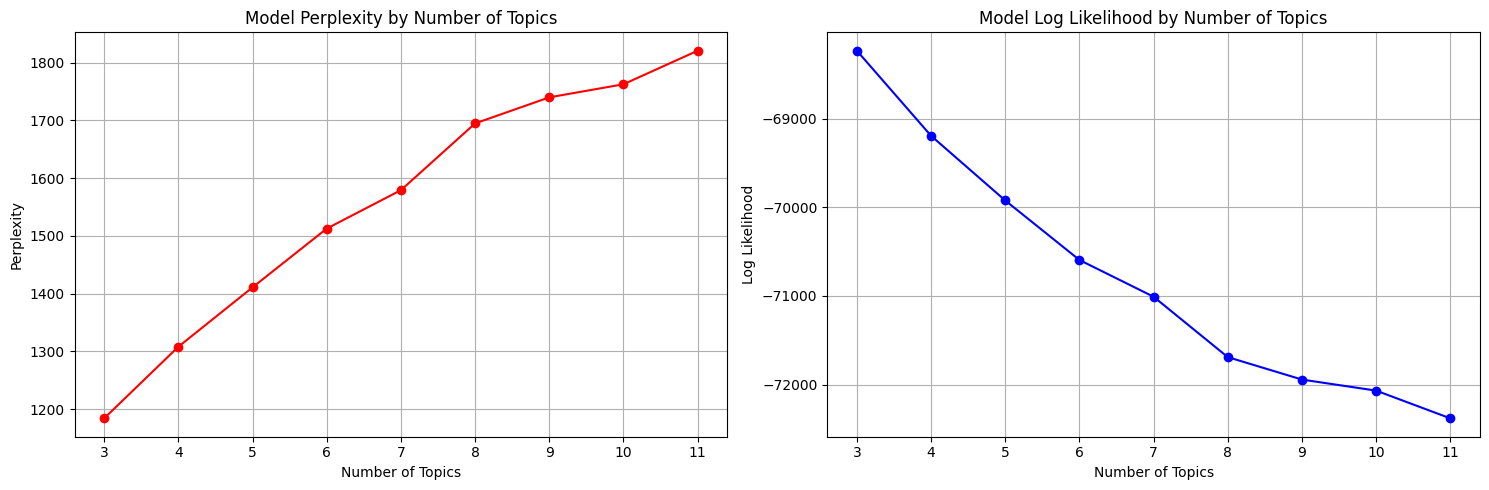


Optimal number of topics: 3 (perplexity: 1184.20)


In [50]:
# Function to compute topic coherence and perplexity
def evaluate_lda_models(doc_term_matrix, topic_range):
    """
    Evaluate LDA models with different numbers of topics
    """
    results = []
    
    for n_topics in topic_range:
        print(f"Evaluating {n_topics} topics...")
        
        # Fit LDA model
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=20,
            learning_method='batch',
            n_jobs=1  # Use single process to avoid serialization issues
        )
        
        lda.fit(doc_term_matrix)
        
        # Calculate perplexity (lower is better)
        perplexity = lda.perplexity(doc_term_matrix)
        
        # Calculate log-likelihood (higher is better)
        log_likelihood = lda.score(doc_term_matrix)
        
        results.append({
            'n_topics': n_topics,
            'perplexity': perplexity,
            'log_likelihood': log_likelihood,
            'model': lda
        })
    
    return results

# Test different numbers of topics
topic_range = range(3, 12)  # Test 3 to 11 topics
print(f"Testing topic range: {list(topic_range)}")

evaluation_results = evaluate_lda_models(doc_term_matrix, topic_range)

# Plot results to find optimal number of topics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

topics = [r['n_topics'] for r in evaluation_results]
perplexities = [r['perplexity'] for r in evaluation_results]
log_likelihoods = [r['log_likelihood'] for r in evaluation_results]

ax1.plot(topics, perplexities, 'bo-', color='red')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Perplexity')
ax1.set_title('Model Perplexity by Number of Topics')
ax1.grid(True)

ax2.plot(topics, log_likelihoods, 'bo-', color='blue')
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Log Likelihood')
ax2.set_title('Model Log Likelihood by Number of Topics')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal number of topics (lowest perplexity)
optimal_result = min(evaluation_results, key=lambda x: x['perplexity'])
optimal_n_topics = optimal_result['n_topics']
print(f"\nOptimal number of topics: {optimal_n_topics} (perplexity: {optimal_result['perplexity']:.2f})")

# 6.3 Training Final LDA Model

In [52]:
# Train the final LDA model with optimal parameters
final_lda = LatentDirichletAllocation(
    n_components=optimal_n_topics,
    random_state=42,
    max_iter=50,
    learning_method='batch',
    n_jobs=1,  # Use single process to avoid serialization issues
    doc_topic_prior=0.1,    # Alpha: lower values = fewer topics per document
    topic_word_prior=0.01   # Beta: lower values = fewer words per topic
)

print(f"Training final LDA model with {optimal_n_topics} topics...")
final_lda.fit(doc_term_matrix)

Training final LDA model with 3 topics...


LatentDirichletAllocation(doc_topic_prior=0.1, max_iter=50, n_components=3,
                          n_jobs=1, random_state=42, topic_word_prior=0.01)

# 6.4 Analyzing Discovered Topics

In [54]:
def display_topics(model, feature_names, n_top_words=10):
    """Display the top words for each topic"""
    topics = []
    
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]
        
        topics.append({
            'topic_id': topic_idx,
            'words': top_words,
            'weights': top_weights
        })
        
        print(f"\nTopic {topic_idx}:")
        for word, weight in zip(top_words, top_weights):
            print(f"  {word}: {weight:.4f}")
    
    return topics

# Display discovered topics
discovered_topics = display_topics(final_lda, feature_names, n_top_words=15)


Topic 0:
  thai: 76.6078
  video: 75.7338
  street: 67.8112
  love: 55.8713
  street food: 55.3205
  like: 51.3497
  singapore: 45.8481
  dish: 45.3332
  vietnamese: 41.7309
  good: 41.1156
  vietnam: 39.9345
  restaurant: 39.0647
  best: 38.7900
  look: 38.2421
  thank: 36.9811

Topic 1:
  recipe: 18.6570
  tbsp: 15.2177
  chicken: 14.1709
  adobo: 11.2116
  sauce: 11.1034
  lemak: 10.7311
  nasi lemak: 10.4416
  tsp: 9.7259
  cup: 9.5688
  oil: 9.0965
  nasi: 8.5901
  garlic: 8.5470
  add: 7.5151
  salt: 7.1034
  onion: 6.9027

Topic 2:
  indonesian: 27.8941
  ang: 26.3369
  indonesia: 25.5277
  jakarta: 21.1010
  dan: 20.5691
  sarap: 19.0672
  goreng: 17.8137
  nasi: 17.1890
  nasi goreng: 14.9768
  mga: 14.8479
  yang: 14.5098
  ako: 11.7102
  ini: 10.3731
  indonesian food: 10.3081
  indonesian street: 10.0082


# 6.5 Interpreting Topics

In [56]:
# Manually interpret and label topics based on top words
def interpret_topics(topics):
    """
    Interpret topics based on their top words
    This function should be customized based on the actual discovered topics
    """
    topic_labels = {}
    
    for i, topic in enumerate(topics):
        top_words = topic['words'][:10]
        
        # Heuristic labeling based on common food travel themes
        if any(word in top_words for word in ['street', 'market', 'vendor', 'hawker']):
            topic_labels[i] = 'Street Food'
        elif any(word in top_words for word in ['restaurant', 'dining', 'fine']):
            topic_labels[i] = 'Restaurant Dining'
        elif any(word in top_words for word in ['cooking', 'recipe', 'kitchen', 'make']):
            topic_labels[i] = 'Cooking & Recipes'
        elif any(word in top_words for word in ['travel', 'trip', 'visit', 'tour']):
            topic_labels[i] = 'Travel Experience'
        elif any(word in top_words for word in ['thai', 'thailand', 'bangkok']):
            topic_labels[i] = 'Thai Cuisine'
        elif any(word in top_words for word in ['vietnam', 'vietnamese', 'pho']):
            topic_labels[i] = 'Vietnamese Cuisine'
        elif any(word in top_words for word in ['malaysia', 'malaysian', 'penang']):
            topic_labels[i] = 'Malaysian Cuisine'
        elif any(word in top_words for word in ['singapore', 'singaporean']):
            topic_labels[i] = 'Singaporean Cuisine'
        elif any(word in top_words for word in ['review', 'taste', 'trying', 'rating']):
            topic_labels[i] = 'Food Reviews'
        else:
            topic_labels[i] = f'Topic_{i}'  # Default label
    
    return topic_labels

topic_labels = interpret_topics(discovered_topics)

print("Topic Labels:")
for topic_id, label in topic_labels.items():
    print(f"Topic {topic_id}: {label}")

Topic Labels:
Topic 0: Street Food
Topic 1: Cooking & Recipes
Topic 2: Topic_2


# 6.6 Creating Topic Features for Videos

In [58]:
# Get topic distributions for each document
doc_topic_distributions = final_lda.transform(doc_term_matrix)

# Create topic feature columns
topic_feature_names = []
for topic_id in range(optimal_n_topics):
    topic_name = f"topic_{topic_id}_{topic_labels[topic_id].lower().replace(' ', '_')}"
    topic_feature_names.append(topic_name)
    df_topic[topic_name] = doc_topic_distributions[:, topic_id]

print(f"Created {len(topic_feature_names)} topic features:")
for name in topic_feature_names:
    print(f"  - {name}")

# Find dominant topic for each video
df_topic['dominant_topic'] = doc_topic_distributions.argmax(axis=1)
df_topic['dominant_topic_prob'] = doc_topic_distributions.max(axis=1)
df_topic['dominant_topic_label'] = df_topic['dominant_topic'].map(topic_labels)

Created 3 topic features:
  - topic_0_street_food
  - topic_1_cooking_&_recipes
  - topic_2_topic_2


# 6.7 Topic Distribution Analysis

Distribution of Dominant Topics:
dominant_topic_label
Street Food          1317
Topic_2               107
Cooking & Recipes      42
Name: count, dtype: int64

Topic Performance Analysis:
                      view_count          engagement_score        is_trending
                            mean   median             mean median        mean
dominant_topic_label                                                         
Cooking & Recipes      26413.690   4968.0            0.049  0.018       0.000
Street Food           222176.995  18258.0            0.035  0.023       0.019
Topic_2               409781.841  71039.0            0.032  0.018       0.000


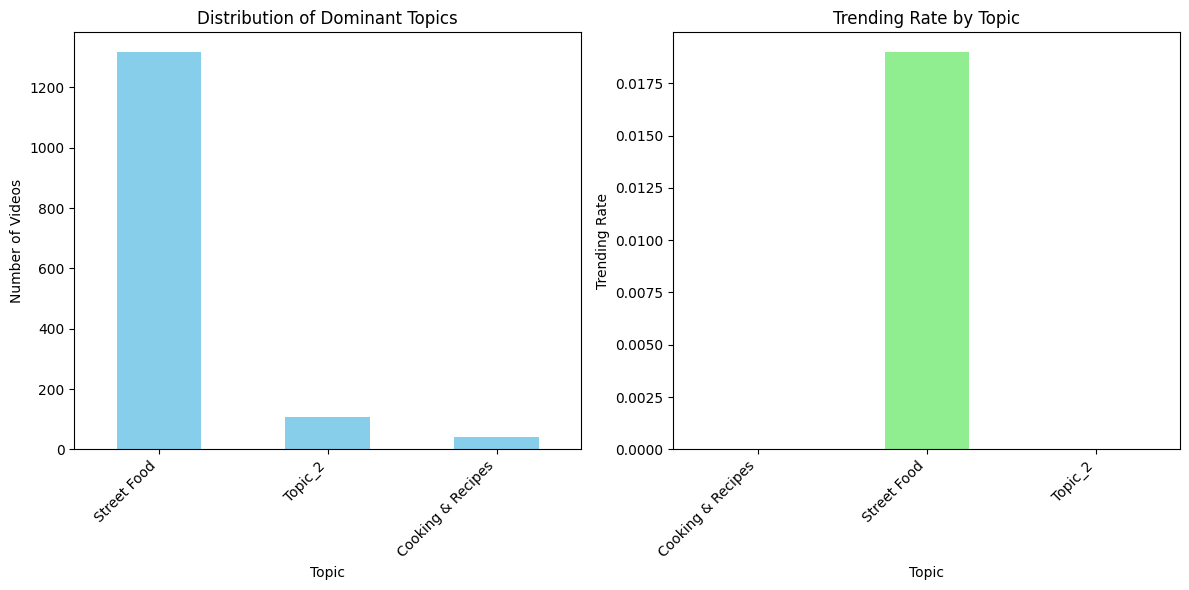

In [60]:
# Analyze topic distribution
topic_distribution = df_topic['dominant_topic_label'].value_counts()
print("Distribution of Dominant Topics:")
print(topic_distribution)

# Topic performance analysis
topic_performance = df_topic.groupby('dominant_topic_label').agg({
    'view_count': ['mean', 'median'],
    'engagement_score': ['mean', 'median'],
    'is_trending': 'mean'
}).round(3)

print("\nTopic Performance Analysis:")
print(topic_performance)

# Create visualization of topic distribution
plt.figure(figsize=(12, 6))

# Plot 1: Topic distribution
plt.subplot(1, 2, 1)
topic_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45, ha='right')

# Plot 2: Topic performance (trending rate)
plt.subplot(1, 2, 2)
trending_by_topic = df_topic.groupby('dominant_topic_label')['is_trending'].mean()
trending_by_topic.plot(kind='bar', color='lightgreen')
plt.title('Trending Rate by Topic')
plt.xlabel('Topic')
plt.ylabel('Trending Rate')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 6.8 Topic Coherence Analysis

In [62]:
# Calculate topic diversity and coherence metrics
def calculate_topic_diversity(topics, n_top_words=25):
    """Calculate topic diversity (unique words across topics)"""
    all_words = set()
    total_words = 0
    
    for topic in topics:
        top_words = set(topic['words'][:n_top_words])
        all_words.update(top_words)
        total_words += len(top_words)
    
    diversity = len(all_words) / total_words
    return diversity

diversity_score = calculate_topic_diversity(discovered_topics)
print(f"Topic Diversity Score: {diversity_score:.3f} (higher = more diverse topics)")

# Find most and least coherent topics based on word weights
topic_coherence = []
for topic in discovered_topics:
    # Use standard deviation of top word weights as coherence proxy
    top_weights = topic['weights'][:10]
    coherence = np.std(top_weights)
    topic_coherence.append(coherence)

most_coherent_topic = np.argmax(topic_coherence)
least_coherent_topic = np.argmin(topic_coherence)

print(f"Most coherent topic: Topic {most_coherent_topic} ({topic_labels[most_coherent_topic]})")
print(f"Least coherent topic: Topic {least_coherent_topic} ({topic_labels[least_coherent_topic]})")

Topic Diversity Score: 0.978 (higher = more diverse topics)
Most coherent topic: Topic 0 (Street Food)
Least coherent topic: Topic 1 (Cooking & Recipes)


# 6.9 Merging Topic Features Back to Main Dataset

In [64]:
# Merge topic features back to the main dataframe
# First, create a mapping dataframe
topic_features_df = df_topic[['video_id'] + topic_feature_names + 
                             ['dominant_topic', 'dominant_topic_prob', 'dominant_topic_label']].copy()

# Merge with main dataframe
df_clean = df_clean.merge(topic_features_df, on='video_id', how='left')

# Fill NaN values for videos without topics (empty text)
topic_cols_to_fill = topic_feature_names + ['dominant_topic_prob']
df_clean[topic_cols_to_fill] = df_clean[topic_cols_to_fill].fillna(0)
df_clean['dominant_topic'] = df_clean['dominant_topic'].fillna(-1)  # -1 for no dominant topic
df_clean['dominant_topic_label'] = df_clean['dominant_topic_label'].fillna('No Topic')

print(f"✅ Topic modeling completed!")
print(f"Added {len(topic_feature_names)} topic probability features")
print(f"Added dominant topic information")
print(f"Total features now: {len(df_clean.columns)}")

# Summary of topic modeling results
print(f"\n📊 Topic Modeling Summary:")
print(f"- Optimal number of topics: {optimal_n_topics}")
print(f"- Documents analyzed: {len(df_topic)}")
print(f"- Vocabulary size: {len(feature_names)}")
print(f"- Topic diversity: {diversity_score:.3f}")
print(f"- Most common topic: {topic_distribution.index[0]} ({topic_distribution.iloc[0]} videos)")


✅ Topic modeling completed!
Added 3 topic probability features
Added dominant topic information
Total features now: 111

📊 Topic Modeling Summary:
- Optimal number of topics: 3
- Documents analyzed: 1466
- Vocabulary size: 1000
- Topic diversity: 0.978
- Most common topic: Street Food (1317 videos)


# 6.10 Topic Word Clouds

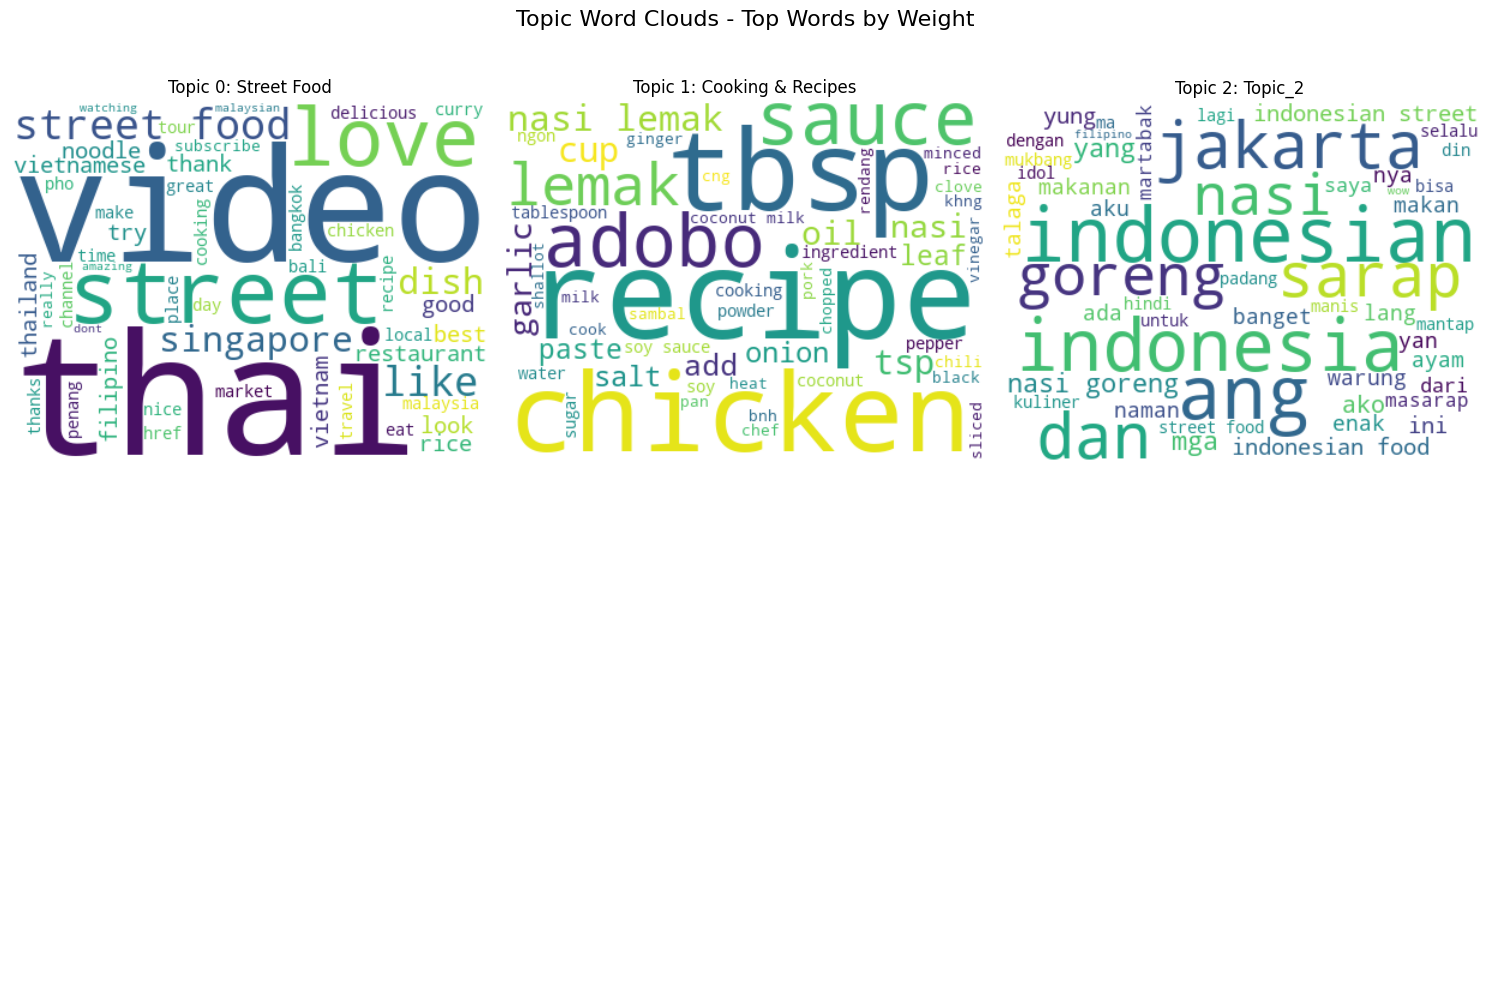

✅ Interactive LDA visualization saved as 'lda_visualization.html'


In [66]:
def create_topic_wordclouds(lda_model, feature_names, n_topics=5, n_words=50):
    """
    Create word clouds for the top topics
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for topic_idx in range(min(n_topics, len(axes))):
        # Get word weights for this topic
        topic = lda_model.components_[topic_idx]
        top_words_idx = topic.argsort()[-n_words:][::-1]
        
        # Create word frequency dict
        word_freq = {}
        for i in top_words_idx:
            word_freq[feature_names[i]] = topic[i]
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=400, 
            height=300, 
            background_color='white',
            relative_scaling=0.5,
            colormap='viridis'
        ).generate_from_frequencies(word_freq)
        
        # Plot
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].set_title(f'Topic {topic_idx}: {topic_labels.get(topic_idx, f"Topic_{topic_idx}")}')
        axes[topic_idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n_topics, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Topic Word Clouds - Top Words by Weight', fontsize=16)
    plt.tight_layout()
    plt.show()

# Create Interactive LDA Visualization
def create_interactive_lda_viz(lda_model, doc_term_matrix, vectorizer):
    """
    Create interactive pyLDAvis visualization
    """
    try:
        # Prepare the visualization
        vis = pyLDAvis.lda_model.prepare(
            lda_model, 
            doc_term_matrix, 
            vectorizer,
            mds='tsne'  # Use t-SNE for better topic separation
        )
        
        # Save as HTML
        pyLDAvis.save_html(vis, 'lda_visualization.html')
        print("✅ Interactive LDA visualization saved as 'lda_visualization.html'")
        
        # Display in notebook if possible
        return vis
    except Exception as e:
        print(f"⚠️ Could not create interactive visualization: {e}")
        return None

# Call visualization functions after LDA training
if 'final_lda' in globals() and 'feature_names' in globals():
    
    # Create word clouds
    create_topic_wordclouds(final_lda, feature_names, n_topics=optimal_n_topics)
    
    # Create interactive visualization
    lda_vis = create_interactive_lda_viz(final_lda, doc_term_matrix, vectorizer)

# 7: Sentiment Analysis

In [68]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [69]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [70]:
# Import required libraries for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter

# 7.1 Initializing Sentiment Analysis Tool

In [72]:
analyzer = SentimentIntensityAnalyzer()

# Download TextBlob corpora (for comparison/validation)
try:
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('brown', quiet=True)
except:
    pass

print("✅ VADER Sentiment Analyzer initialized")
print("✅ TextBlob ready for comparison analysis")

✅ VADER Sentiment Analyzer initialized
✅ TextBlob ready for comparison analysis


# 7.2 Preprocessing Comments for Sentiment Analysis

In [74]:
def clean_comment_text(text):
    """
    Clean comment text for better sentiment analysis
    
    Args:
        text (str): Raw comment text
        
    Returns:
        str: Cleaned comment text
    """
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text)
    
    # Split multiple comments (separated by |)
    comments = text.split('|')
    
    # Clean each comment
    cleaned_comments = []
    for comment in comments:
        comment = comment.strip()
        if len(comment) > 0:
            # Remove excessive punctuation and emojis for better analysis
            comment = re.sub(r'[^\w\s!?.,]', ' ', comment)
            comment = re.sub(r'\s+', ' ', comment).strip()
            if len(comment) > 3:  # Only keep meaningful comments
                cleaned_comments.append(comment)
    
    return ' | '.join(cleaned_comments)

# Apply comment cleaning
df_clean['comments_cleaned'] = df_clean['comments_text'].apply(clean_comment_text)

# Filter videos with meaningful comments for sentiment analysis
df_sentiment = df_clean[df_clean['comments_cleaned'].str.len() > 0].copy()
print(f"Videos with comments for sentiment analysis: {len(df_sentiment)}")


Videos with comments for sentiment analysis: 1294


# 7.3 Vader Sentiment Analysis

In [76]:
def analyze_comment_sentiment_vader(text):
    """
    Analyze sentiment using VADER for each video's comments
    
    Args:
        text (str): Combined comment text
        
    Returns:
        dict: Sentiment scores and metrics
    """
    if not text or text.strip() == '':
        return {
            'compound': 0, 'positive': 0, 'neutral': 0, 'negative': 0,
            'comment_count': 0, 'avg_compound': 0, 'sentiment_consistency': 0
        }
    
    # Split individual comments
    comments = [c.strip() for c in text.split('|') if c.strip()]
    
    if not comments:
        return {
            'compound': 0, 'positive': 0, 'neutral': 0, 'negative': 0,
            'comment_count': 0, 'avg_compound': 0, 'sentiment_consistency': 0
        }
    
    # Analyze each comment
    sentiments = []
    for comment in comments:
        score = analyzer.polarity_scores(comment)
        sentiments.append(score)
    
    # Aggregate sentiment scores
    if sentiments:
        avg_compound = np.mean([s['compound'] for s in sentiments])
        avg_positive = np.mean([s['pos'] for s in sentiments])
        avg_neutral = np.mean([s['neu'] for s in sentiments])
        avg_negative = np.mean([s['neg'] for s in sentiments])
        
        # Calculate sentiment consistency (lower std = more consistent sentiment)
        compound_scores = [s['compound'] for s in sentiments]
        sentiment_consistency = 1 / (np.std(compound_scores) + 0.1)  # +0.1 to avoid division by zero
        
        return {
            'compound': avg_compound,
            'positive': avg_positive,
            'neutral': avg_neutral,
            'negative': avg_negative,
            'comment_count': len(comments),
            'avg_compound': avg_compound,
            'sentiment_consistency': sentiment_consistency
        }
    
    return {
        'compound': 0, 'positive': 0, 'neutral': 0, 'negative': 0,
        'comment_count': 0, 'avg_compound': 0, 'sentiment_consistency': 0
    }

print("Analyzing sentiment for comments...")

# Apply VADER sentiment analysis
sentiment_results = df_sentiment['comments_cleaned'].apply(analyze_comment_sentiment_vader)

# Extract sentiment features
sentiment_features = pd.DataFrame(sentiment_results.tolist())
sentiment_features.index = df_sentiment.index

# Add sentiment features to dataframe
for col in sentiment_features.columns:
    df_sentiment[f'sentiment_{col}'] = sentiment_features[col]

Analyzing sentiment for comments...


# 7.4 Sentiment Classification and Labeling

In [78]:
def classify_sentiment(compound_score):
    """
    Classify sentiment based on compound score
    VADER compound scores: -1 (most negative) to +1 (most positive)
    """
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Create sentiment labels
df_sentiment['sentiment_label'] = df_sentiment['sentiment_compound'].apply(classify_sentiment)

# Create more granular sentiment categories
def classify_sentiment_detailed(compound_score):
    if compound_score >= 0.5:
        return 'Very Positive'
    elif compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.5:
        return 'Very Negative'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_sentiment['sentiment_detailed'] = df_sentiment['sentiment_compound'].apply(classify_sentiment_detailed)

# 7.5 Sentiment Distribution Analysis

In [80]:
# Overall sentiment distribution
sentiment_dist = df_sentiment['sentiment_label'].value_counts()
print("Overall Sentiment Distribution:")
print(sentiment_dist)
print(f"Sentiment percentages:")
for label, count in sentiment_dist.items():
    percentage = (count / len(df_sentiment)) * 100
    print(f"- {label}: {percentage:.1f}%")

# Detailed sentiment distribution
detailed_dist = df_sentiment['sentiment_detailed'].value_counts()
print(f"\nDetailed Sentiment Distribution:")
print(detailed_dist)


Overall Sentiment Distribution:
sentiment_label
Positive    1172
Neutral      102
Negative      20
Name: count, dtype: int64
Sentiment percentages:
- Positive: 90.6%
- Neutral: 7.9%
- Negative: 1.5%

Detailed Sentiment Distribution:
sentiment_detailed
Positive         644
Very Positive    528
Neutral          102
Negative          19
Very Negative      1
Name: count, dtype: int64


# 7.6 Sentiment vs Performance Analysis

In [82]:
print("7.6 Sentiment vs Performance Analysis")
print("-" * 40)

# Analyze how sentiment relates to video performance
sentiment_performance = df_sentiment.groupby('sentiment_label').agg({
    'view_count': ['mean', 'median', 'std'],
    'like_count': ['mean', 'median'],
    'engagement_score': ['mean', 'median'],
    'is_trending': ['mean', 'count']
}).round(3)

print("Performance by Sentiment:")
print(sentiment_performance)

# Statistical significance test
from scipy.stats import f_oneway

# Test if there's significant difference in engagement across sentiment categories
positive_engagement = df_sentiment[df_sentiment['sentiment_label'] == 'Positive']['engagement_score']
neutral_engagement = df_sentiment[df_sentiment['sentiment_label'] == 'Neutral']['engagement_score']
negative_engagement = df_sentiment[df_sentiment['sentiment_label'] == 'Negative']['engagement_score']

if len(positive_engagement) > 0 and len(neutral_engagement) > 0 and len(negative_engagement) > 0:
    f_stat, p_value = f_oneway(positive_engagement, neutral_engagement, negative_engagement)
    print(f"\nANOVA Test for Engagement vs Sentiment:")
    print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")
    if p_value < 0.05:
        print(" Significant difference in engagement across sentiment categories")
    else:
        print(" No significant difference in engagement across sentiment categories")


7.6 Sentiment vs Performance Analysis
----------------------------------------
Performance by Sentiment:
                 view_count                      like_count         \
                       mean   median         std       mean median   
sentiment_label                                                      
Negative         211420.550  13846.0  712997.382   4869.450  108.5   
Neutral           83346.412  11095.5  228607.222   1008.039  152.0   
Positive         276557.260  28653.5  948202.600   5037.187  653.0   

                engagement_score        is_trending        
                            mean median        mean count  
sentiment_label                                            
Negative                   0.013  0.012       0.000    20  
Neutral                    0.023  0.015       0.000   102  
Positive                   0.038  0.025       0.021  1172  

ANOVA Test for Engagement vs Sentiment:
F-statistic: 4.467, p-value: 0.012
 Significant difference in engagement 

# 7.7 Sentiment Trend Analysis

In [84]:
# Analyze sentiment trends over time
df_sentiment['publish_month_year'] = df_sentiment['published_at'].dt.to_period('M')

# Monthly sentiment trends
monthly_sentiment = df_sentiment.groupby(['publish_month_year', 'sentiment_label']).size().unstack(fill_value=0)
monthly_sentiment_pct = monthly_sentiment.div(monthly_sentiment.sum(axis=1), axis=0) * 100

print("Monthly Sentiment Trends (last 6 months):")
if len(monthly_sentiment_pct) > 0:
    recent_months = monthly_sentiment_pct.tail(6)
    print(recent_months.round(1))


Monthly Sentiment Trends (last 6 months):
sentiment_label     Negative  Neutral  Positive
publish_month_year                             
2025-03                  0.0      6.2      93.8
2025-04                  1.2      5.9      92.9
2025-05                  2.8      6.9      90.3
2025-06                  0.0     16.1      83.9
2025-07                  1.5      8.4      90.1
2025-08                  0.0     10.7      89.3


# 7.8 Advanced Sentiment Features

In [86]:
# Create advanced sentiment features
def calculate_sentiment_metrics(df):
    """Calculate advanced sentiment-based features"""
    
    # Sentiment strength (absolute value of compound score)
    df['sentiment_strength'] = abs(df['sentiment_compound'])
    
    # Sentiment polarity (how extreme the sentiment is)
    df['sentiment_polarity'] = df['sentiment_positive'] - df['sentiment_negative']
    
    # Emotional engagement (high positive or negative sentiment)
    df['emotional_engagement'] = (df['sentiment_positive'] + df['sentiment_negative'])
    
    # Comment sentiment quality score
    df['comment_sentiment_quality'] = (
        df['sentiment_compound'] * df['sentiment_sentiment_consistency'] * 
        np.log1p(df['sentiment_comment_count'])  # Weight by number of comments
    )
    
    return df

df_sentiment = calculate_sentiment_metrics(df_sentiment)

# 7.9 Sentiment and Topic Interaction Analysis

In [88]:
# Analyze sentiment by topic (if topic features exist)
if 'dominant_topic_label' in df_sentiment.columns:
    topic_sentiment = df_sentiment.groupby('dominant_topic_label').agg({
        'sentiment_compound': ['mean', 'std'],
        'sentiment_positive': 'mean',
        'sentiment_negative': 'mean',
        'emotional_engagement': 'mean'
    }).round(3)
    
    print("Sentiment by Topic:")
    print(topic_sentiment)
    
    # Find topics with most positive/negative sentiment
    avg_sentiment_by_topic = df_sentiment.groupby('dominant_topic_label')['sentiment_compound'].mean().sort_values(ascending=False)
    print(f"\nMost Positive Topic: {avg_sentiment_by_topic.index[0]} ({avg_sentiment_by_topic.iloc[0]:.3f})")
    print(f"Most Negative Topic: {avg_sentiment_by_topic.index[-1]} ({avg_sentiment_by_topic.iloc[-1]:.3f})")

Sentiment by Topic:
                     sentiment_compound        sentiment_positive  \
                                   mean    std               mean   
dominant_topic_label                                                
Cooking & Recipes                 0.252  0.239              0.191   
Street Food                       0.443  0.224              0.252   
Topic_2                           0.135  0.140              0.093   

                     sentiment_negative emotional_engagement  
                                   mean                 mean  
dominant_topic_label                                          
Cooking & Recipes                 0.020                0.211  
Street Food                       0.021                0.274  
Topic_2                           0.015                0.108  

Most Positive Topic: Street Food (0.443)
Most Negative Topic: Topic_2 (0.135)


# 7.10 Creating Visualisations

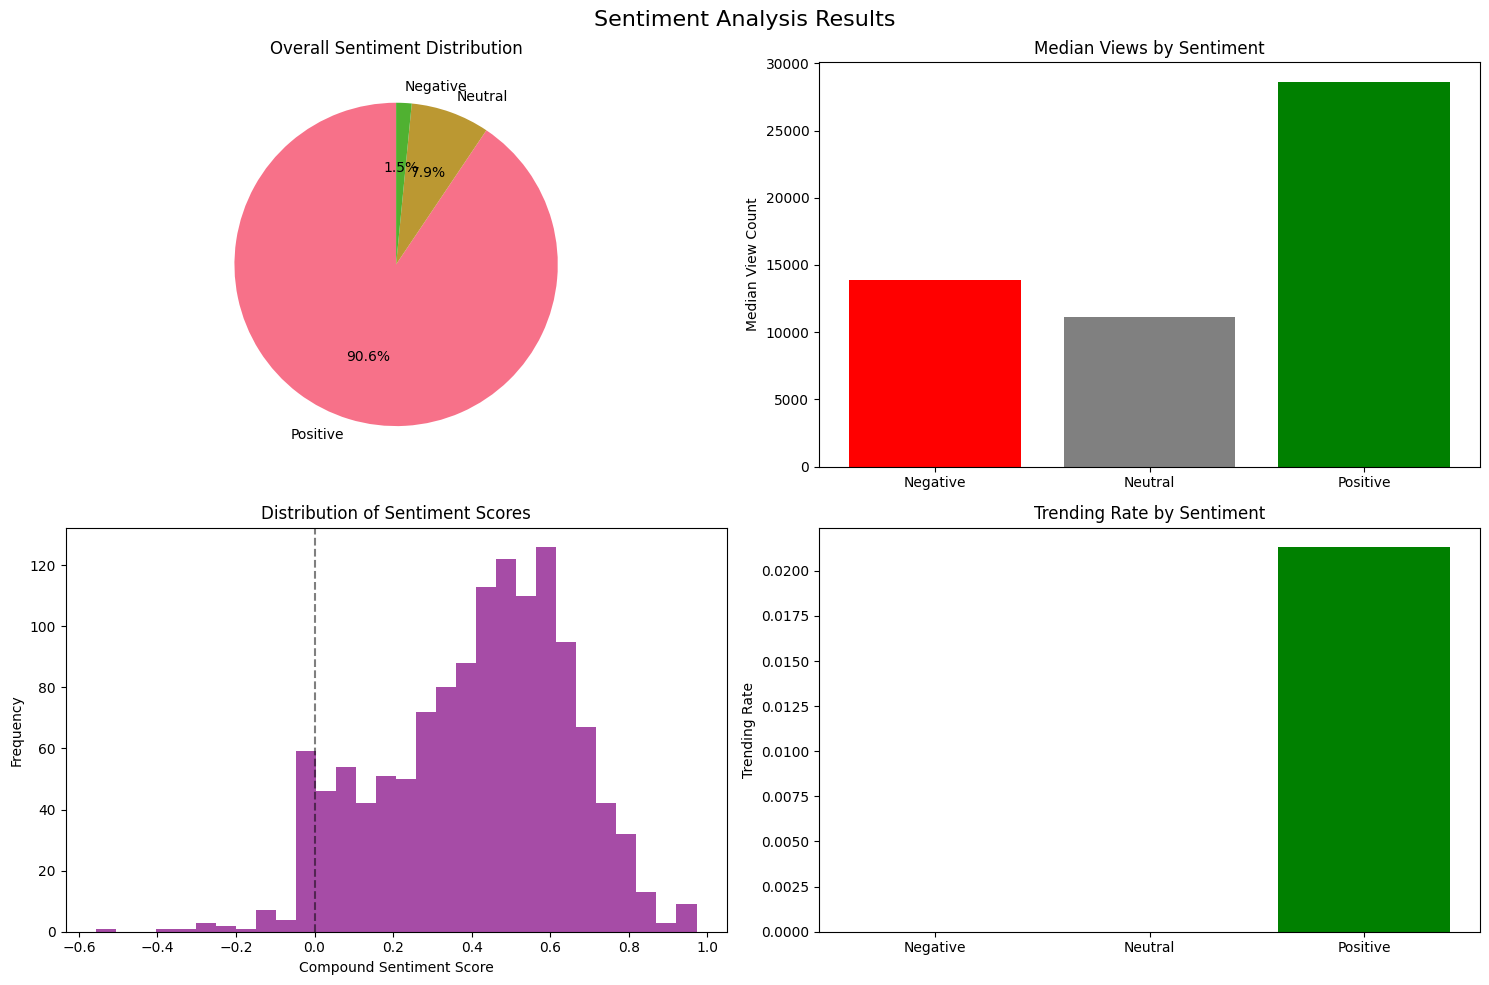

In [90]:
# Create sentiment analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sentiment Analysis Results', fontsize=16)

# 1. Sentiment distribution
axes[0,0].pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Overall Sentiment Distribution')

# 2. Sentiment vs Views
sentiment_views = df_sentiment.groupby('sentiment_label')['view_count'].median()
axes[0,1].bar(sentiment_views.index, sentiment_views.values, color=['red', 'gray', 'green'])
axes[0,1].set_title('Median Views by Sentiment')
axes[0,1].set_ylabel('Median View Count')

# 3. Sentiment compound score distribution
axes[1,0].hist(df_sentiment['sentiment_compound'], bins=30, alpha=0.7, color='purple')
axes[1,0].set_title('Distribution of Sentiment Scores')
axes[1,0].set_xlabel('Compound Sentiment Score')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(x=0, color='black', linestyle='--', alpha=0.5)

# 4. Trending rate by sentiment
trending_by_sentiment = df_sentiment.groupby('sentiment_label')['is_trending'].mean()
axes[1,1].bar(trending_by_sentiment.index, trending_by_sentiment.values, color=['red', 'gray', 'green'])
axes[1,1].set_title('Trending Rate by Sentiment')
axes[1,1].set_ylabel('Trending Rate')

plt.tight_layout()
plt.show()

# 7.11 Merging Sentiment Features Back to Main Dataset

In [92]:
# Create sentiment features dataframe
sentiment_feature_cols = [col for col in df_sentiment.columns if col.startswith('sentiment_') or col in ['sentiment_label', 'sentiment_detailed']]
sentiment_features_df = df_sentiment[['video_id'] + sentiment_feature_cols].copy()

# Merge back to main dataframe
df_clean = df_clean.merge(sentiment_features_df, on='video_id', how='left')

# Fill NaN values for videos without comments
sentiment_numeric_cols = [col for col in sentiment_feature_cols if col.startswith('sentiment_') and col not in ['sentiment_label', 'sentiment_detailed']]
df_clean[sentiment_numeric_cols] = df_clean[sentiment_numeric_cols].fillna(0)
df_clean['sentiment_label'] = df_clean['sentiment_label'].fillna('No Comments')
df_clean['sentiment_detailed'] = df_clean['sentiment_detailed'].fillna('No Comments')

print(f"✅ Sentiment analysis completed!")
print(f"Added {len(sentiment_feature_cols)} sentiment features")
print(f"Total features now: {len(df_clean.columns)}")

# Summary of sentiment analysis results
print(f"\n📊 Sentiment Analysis Summary:")
print(f"- Videos analyzed: {len(df_sentiment)}")
print(f"- Positive sentiment: {sentiment_dist.get('Positive', 0)} videos ({(sentiment_dist.get('Positive', 0)/len(df_sentiment)*100):.1f}%)")
print(f"- Neutral sentiment: {sentiment_dist.get('Neutral', 0)} videos ({(sentiment_dist.get('Neutral', 0)/len(df_sentiment)*100):.1f}%)")
print(f"- Negative sentiment: {sentiment_dist.get('Negative', 0)} videos ({(sentiment_dist.get('Negative', 0)/len(df_sentiment)*100):.1f}%)")
print(f"- Average sentiment score: {df_sentiment['sentiment_compound'].mean():.3f}")

if 'dominant_topic_label' in df_sentiment.columns:
    print(f"- Most positive topic: {avg_sentiment_by_topic.index[0]}")
    print(f"- Most negative topic: {avg_sentiment_by_topic.index[-1]}")

✅ Sentiment analysis completed!
Added 11 sentiment features
Total features now: 123

📊 Sentiment Analysis Summary:
- Videos analyzed: 1294
- Positive sentiment: 1172 videos (90.6%)
- Neutral sentiment: 102 videos (7.9%)
- Negative sentiment: 20 videos (1.5%)
- Average sentiment score: 0.416
- Most positive topic: Street Food
- Most negative topic: Topic_2


# 8: Statistical Trend Detection

In [94]:
# Import required libraries for trend detection
from scipy import stats
from scipy.stats import zscore
import warnings
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta



# 8.1 Preparing Data for Trend Analysis

In [96]:
# Create a working copy with datetime index for time series analysis
df_trend = df_clean.copy()
df_trend['published_at'] = pd.to_datetime(df_trend['published_at'])
df_trend = df_trend.sort_values('published_at')

# Create time-based groupings for trend analysis
df_trend['week'] = df_trend['published_at'].dt.to_period('W')
df_trend['month'] = df_trend['published_at'].dt.to_period('M')
df_trend['quarter'] = df_trend['published_at'].dt.to_period('Q')

print(f"Data prepared for trend analysis: {len(df_trend)} videos")
print(f"Date range: {df_trend['published_at'].min()} to {df_trend['published_at'].max()}")

Data prepared for trend analysis: 1466 videos
Date range: 2023-08-04 17:00:24+00:00 to 2025-08-02 15:00:05+00:00


# 8.2 Z-Score Anomaly Detection

In [98]:
def calculate_zscore_trends(df, metrics, time_period='week'):
    """
    Calculate Z-scores for performance metrics to identify unusual performance
    
    Args:
        df: DataFrame with video data
        metrics: List of metrics to analyze
        time_period: Time period for grouping ('week', 'month', 'quarter')
    
    Returns:
        DataFrame with Z-score trends
    """
    time_col = time_period
    
    # Group by time period and calculate metrics
    time_grouped = df.groupby(time_col).agg({
        metric: ['mean', 'median', 'std', 'count'] for metric in metrics
    }).round(3)
    
    # Flatten column names
    time_grouped.columns = ['_'.join(col).strip() for col in time_grouped.columns]
    
    # Calculate Z-scores for trend detection
    trend_results = {}
    
    for metric in metrics:
        mean_col = f"{metric}_mean"
        if mean_col in time_grouped.columns:
            # Calculate Z-scores for the mean values over time
            values = time_grouped[mean_col].dropna()
            if len(values) > 3:  # Need enough data points
                z_scores = zscore(values)
                
                # Identify trending periods (|Z-score| > 1.96 ≈ 95% confidence)
                trending_periods = time_grouped.index[abs(z_scores) > 1.96]
                
                trend_results[metric] = {
                    'z_scores': z_scores,
                    'trending_periods': trending_periods,
                    'values': values,
                    'mean': values.mean(),
                    'std': values.std()
                }
    
    return time_grouped, trend_results

# Define key metrics for trend analysis
trend_metrics = [
    'view_count', 'like_count', 'comment_count', 
    'engagement_score', 'duration_seconds'
]

print("Calculating weekly trends...")
weekly_data, weekly_trends = calculate_zscore_trends(df_trend, trend_metrics, 'week')

print("Calculating monthly trends...")
monthly_data, monthly_trends = calculate_zscore_trends(df_trend, trend_metrics, 'month')

# Display trend detection results
print(f"\nWeekly Trend Detection Results:")
for metric, trend_info in weekly_trends.items():
    if len(trend_info['trending_periods']) > 0:
        print(f"- {metric}: {len(trend_info['trending_periods'])} trending periods detected")
        print(f"  Periods: {list(trend_info['trending_periods'])}")

Calculating weekly trends...
Calculating monthly trends...

Weekly Trend Detection Results:
- view_count: 6 trending periods detected
  Periods: [Period('2023-08-14/2023-08-20', 'W-SUN'), Period('2023-09-11/2023-09-17', 'W-SUN'), Period('2023-10-16/2023-10-22', 'W-SUN'), Period('2024-01-01/2024-01-07', 'W-SUN'), Period('2024-03-04/2024-03-10', 'W-SUN'), Period('2024-03-25/2024-03-31', 'W-SUN')]
- like_count: 5 trending periods detected
  Periods: [Period('2023-09-11/2023-09-17', 'W-SUN'), Period('2024-03-04/2024-03-10', 'W-SUN'), Period('2024-03-18/2024-03-24', 'W-SUN'), Period('2024-03-25/2024-03-31', 'W-SUN'), Period('2024-05-27/2024-06-02', 'W-SUN')]
- comment_count: 5 trending periods detected
  Periods: [Period('2024-02-26/2024-03-03', 'W-SUN'), Period('2024-03-04/2024-03-10', 'W-SUN'), Period('2024-03-18/2024-03-24', 'W-SUN'), Period('2024-03-25/2024-03-31', 'W-SUN'), Period('2024-05-27/2024-06-02', 'W-SUN')]
- engagement_score: 5 trending periods detected
  Periods: [Period('202

# 8.3 Moving Average Trend Analysis

In [100]:
def calculate_moving_averages(df, metrics, windows=[7, 14, 30]):
    """
    Calculate moving averages for trend smoothing and detection
    
    Args:
        df: DataFrame with time series data
        metrics: List of metrics to analyze
        windows: List of window sizes for moving averages
    
    Returns:
        DataFrame with moving averages
    """
    df_ma = df.copy()
    
    for metric in metrics:
        for window in windows:
            col_name = f"{metric}_ma_{window}d"
            df_ma[col_name] = df_ma[metric].rolling(window=window, min_periods=1).mean()
            
            # Calculate trend direction (increasing/decreasing)
            trend_col = f"{metric}_trend_{window}d"
            df_ma[trend_col] = df_ma[col_name].diff().fillna(0)
            
            # Normalize trend direction (-1 to 1)
            if df_ma[trend_col].std() > 0:
                df_ma[f"{metric}_trend_normalized_{window}d"] = (
                    df_ma[trend_col] / df_ma[trend_col].std()
                ).clip(-3, 3)  # Clip extreme values
    
    return df_ma

# Calculate moving averages
print("Calculating moving averages (7, 14, 30 day windows)...")
df_trend = calculate_moving_averages(df_trend, trend_metrics)

# Analyze current trends
print(f"\nCurrent Trend Analysis (last 30 videos):")
recent_data = df_trend.tail(30)

for metric in trend_metrics:
    if f"{metric}_trend_normalized_14d" in recent_data.columns:
        avg_trend = recent_data[f"{metric}_trend_normalized_14d"].mean()
        trend_direction = "📈 Increasing" if avg_trend > 0.1 else "📉 Decreasing" if avg_trend < -0.1 else "➡️ Stable"
        print(f"- {metric}: {trend_direction} (trend score: {avg_trend:.3f})")

Calculating moving averages (7, 14, 30 day windows)...

Current Trend Analysis (last 30 videos):
- view_count: ➡️ Stable (trend score: 0.000)
- like_count: ➡️ Stable (trend score: 0.001)
- comment_count: ➡️ Stable (trend score: 0.004)
- engagement_score: 📈 Increasing (trend score: 0.201)
- duration_seconds: 📈 Increasing (trend score: 0.146)


# 8.4 Keyword and Topic Trend Detection

In [102]:
def analyze_keyword_trends(df, text_column, time_period='month', min_frequency=5):
    """
    Analyze trending keywords over time
    
    Args:
        df: DataFrame with text data
        text_column: Column containing text to analyze
        time_period: Time period for analysis
        min_frequency: Minimum frequency for keyword inclusion
    
    Returns:
        Dictionary with keyword trends
    """
    # Extract keywords from text
    from collections import Counter
    import re
    
    # Group by time period
    time_col = time_period
    keyword_trends = {}
    
    for period in df[time_col].unique():
        period_data = df[df[time_col] == period]
        
        # Extract all words from the text column
        all_text = ' '.join(period_data[text_column].fillna('').astype(str))
        
        # Simple keyword extraction (you could use more sophisticated NLP here)
        words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
        
        # Count keyword frequencies
        word_counts = Counter(words)
        
        # Filter out common words and keep only frequent keywords
        stop_words = {'the', 'and', 'for', 'are', 'with', 'this', 'that', 'from', 'they', 'have', 'been', 'were', 'said', 'each', 'which', 'their', 'but', 'can', 'had', 'has', 'was', 'one', 'our', 'out', 'day', 'get', 'use', 'man', 'new', 'now', 'way', 'may', 'say'}
        
        filtered_counts = {word: count for word, count in word_counts.items() 
                          if word not in stop_words and count >= min_frequency}
        
        keyword_trends[period] = filtered_counts
    
    return keyword_trends

# Analyze title keyword trends
if 'title_processed' in df_trend.columns:
    print("Analyzing title keyword trends...")
    title_trends = analyze_keyword_trends(df_trend, 'title_processed', 'month')
    
    # Find emerging keywords (appearing in recent months but not earlier)
    all_periods = sorted(title_trends.keys())
    if len(all_periods) >= 2:
        recent_period = all_periods[-1]
        previous_period = all_periods[-2]
        
        recent_keywords = set(title_trends[recent_period].keys())
        previous_keywords = set(title_trends[previous_period].keys())
        
        emerging_keywords = recent_keywords - previous_keywords
        declining_keywords = previous_keywords - recent_keywords
        
        print(f"\nEmerging keywords in {recent_period}:")
        for keyword in list(emerging_keywords)[:10]:
            frequency = title_trends[recent_period][keyword]
            print(f"  - {keyword}: {frequency} mentions")
        
        if declining_keywords:
            print(f"\nDeclining keywords from {previous_period}:")
            for keyword in list(declining_keywords)[:5]:
                frequency = title_trends[previous_period][keyword]
                print(f"  - {keyword}: was {frequency} mentions")

Analyzing title keyword trends...

Emerging keywords in 2025-08:
  - asmr: 9 mentions
  - mukbang: 9 mentions

Declining keywords from 2025-07:
  - authentic: was 8 mentions
  - green: was 6 mentions
  - hour: was 6 mentions
  - chicken: was 12 mentions
  - eat: was 9 mentions


# 8.5 Topic Momentum Analysis

In [104]:
# Analyze topic trends over time (if topic features exist)
topic_cols = [col for col in df_trend.columns if col.startswith('topic_') and col.endswith('_cuisine') or col.endswith('_food') or col.endswith('_experience')]

if len(topic_cols) > 0:
    print("Analyzing topic momentum...")
    
    # Calculate topic momentum (rate of change in topic probability)
    topic_momentum = {}
    
    for topic_col in topic_cols[:5]:  # Analyze top 5 topics
        # Group by month and calculate average topic probability
        monthly_topic = df_trend.groupby('month')[topic_col].mean()
        
        if len(monthly_topic) > 2:
            # Calculate momentum (rate of change)
            momentum = monthly_topic.diff().fillna(0)
            
            # Calculate Z-score of momentum to identify significant changes
            if momentum.std() > 0:
                momentum_zscore = zscore(momentum.dropna())
                
                topic_momentum[topic_col] = {
                    'current_momentum': momentum.iloc[-1] if len(momentum) > 0 else 0,
                    'avg_momentum': momentum.mean(),
                    'momentum_zscore': momentum_zscore[-1] if len(momentum_zscore) > 0 else 0,
                    'monthly_values': monthly_topic
                }
    
    # Display topic momentum results
    print("Topic Momentum Analysis:")
    for topic, momentum_data in topic_momentum.items():
        topic_name = topic.replace('topic_', '').replace('_', ' ').title()
        momentum_score = momentum_data['current_momentum']
        momentum_direction = "🚀 Rising" if momentum_score > 0.01 else "📉 Falling" if momentum_score < -0.01 else "➡️ Stable"
        print(f"- {topic_name}: {momentum_direction} (momentum: {momentum_score:.4f})")


Analyzing topic momentum...
Topic Momentum Analysis:
- Is Street Food: 📉 Falling (momentum: -0.1776)
- 0 Street Food: 📉 Falling (momentum: -0.2007)


# 8.6 Engagement Velocity Analysis

In [106]:
def calculate_engagement_velocity(df):
    """
    Calculate how quickly videos gain engagement after publication
    """
    # Calculate engagement per day since publication
    df['engagement_velocity'] = df['engagement_score'] / (df['days_since_publication'] + 1)
    
    # Calculate Z-scores for engagement velocity
    df['engagement_velocity_zscore'] = zscore(df['engagement_velocity'].fillna(0))
    
    # Identify videos with unusually high engagement velocity
    high_velocity_threshold = 1.96  # 95% confidence
    df['high_engagement_velocity'] = (df['engagement_velocity_zscore'] > high_velocity_threshold).astype(int)
    
    return df

df_trend = calculate_engagement_velocity(df_trend)

# Analyze engagement velocity patterns
high_velocity_count = df_trend['high_engagement_velocity'].sum()
print(f"Videos with high engagement velocity: {high_velocity_count} ({high_velocity_count/len(df_trend)*100:.1f}%)")

# Analyze what drives high engagement velocity
if high_velocity_count > 0:
    velocity_analysis = df_trend.groupby('high_engagement_velocity').agg({
        'view_count': 'mean',
        'like_to_view_ratio': 'mean',
        'duration_seconds': 'mean',
        'is_trending': 'mean'
    }).round(3)
    
    print("High vs Normal Engagement Velocity Comparison:")
    print(velocity_analysis)

Videos with high engagement velocity: 24 (1.6%)
High vs Normal Engagement Velocity Comparison:
                          view_count  like_to_view_ratio  duration_seconds  \
high_engagement_velocity                                                     
0                         234075.388               0.027           678.069   
1                           1101.083               0.171           505.333   

                          is_trending  
high_engagement_velocity               
0                               0.017  
1                               0.000  


# 8.7 Seasonal and Cyclical Pattern Detection

In [108]:
def detect_seasonal_patterns(df):
    """
    Detect seasonal patterns in video performance
    """
    # Analyze performance by day of week
    dow_performance = df.groupby('publish_day_of_week').agg({
        'view_count': 'mean',
        'engagement_score': 'mean',
        'is_trending': 'mean'
    }).round(3)
    
    # Analyze performance by hour of day
    hour_performance = df.groupby('publish_hour').agg({
        'view_count': 'mean',
        'engagement_score': 'mean',
        'is_trending': 'mean'
    }).round(3)
    
    # Analyze performance by month
    month_performance = df.groupby('publish_month').agg({
        'view_count': 'mean',
        'engagement_score': 'mean',
        'is_trending': 'mean'
    }).round(3)
    
    return dow_performance, hour_performance, month_performance

dow_perf, hour_perf, month_perf = detect_seasonal_patterns(df_trend)

# Find optimal posting patterns
best_dow = dow_perf['is_trending'].idxmax()
best_hour = hour_perf['is_trending'].idxmax()
best_month = month_perf['is_trending'].idxmax()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print(f"Optimal posting patterns:")
print(f"- Best day of week: {day_names[best_dow]} (trending rate: {dow_perf.loc[best_dow, 'is_trending']:.3f})")
print(f"- Best hour: {best_hour}:00 (trending rate: {hour_perf.loc[best_hour, 'is_trending']:.3f})")
print(f"- Best month: {month_names[best_month-1]} (trending rate: {month_perf.loc[best_month, 'is_trending']:.3f})")

Optimal posting patterns:
- Best day of week: Friday (trending rate: 0.026)
- Best hour: 19:00 (trending rate: 0.062)
- Best month: Mar (trending rate: 0.065)


# 8.8 Creating Trend-Based Features

In [110]:
# Create trend-based features for machine learning
def create_trend_features(df):
    """
    Create features based on trend analysis for ML model
    """
    # Current performance vs historical average
    df['views_vs_historical_avg'] = df['view_count'] / df['view_count'].mean()
    df['engagement_vs_historical_avg'] = df['engagement_score'] / df['engagement_score'].mean()
    
    # Performance vs recent trend (only if moving average columns exist)
    if 'view_count_ma_14d' in df.columns:
        df['views_vs_recent_trend'] = df['view_count'] / (df['view_count_ma_14d'] + 1)  # +1 to avoid division by zero
    if 'engagement_score_ma_14d' in df.columns:
        df['engagement_vs_recent_trend'] = df['engagement_score'] / (df['engagement_score_ma_14d'] + 1)
    
    # Performance vs channel average (only if channel features exist)
    if 'channel_view_count_mean' in df.columns:
        df['views_vs_channel_avg'] = df['view_count'] / (df['channel_view_count_mean'] + 1)
    if 'channel_engagement_score_mean' in df.columns:
        df['engagement_vs_channel_avg'] = df['engagement_score'] / (df['channel_engagement_score_mean'] + 1)
    
    # Trending momentum indicators
    df['is_peak_performance_day'] = (df['publish_day_of_week'] == best_dow).astype(int)
    df['is_peak_performance_hour'] = (df['publish_hour'] == best_hour).astype(int)
    df['is_peak_performance_month'] = (df['publish_month'] == best_month).astype(int)
    
    # Combine timing features
    df['optimal_timing_score'] = (
        df['is_peak_performance_day'] + 
        df['is_peak_performance_hour'] + 
        df['is_peak_performance_month']
    ) / 3
    
    return df

df_trend = create_trend_features(df_trend)

# 8.9 Trend Prediction Signals

In [112]:
# Create early trend detection signals
def create_trend_signals(df):
    """
    Create signals that might predict trending content early
    """
    # Early engagement indicators
    df['early_like_ratio'] = df['like_count'] / (df['view_count'] + 1)
    df['early_comment_ratio'] = df['comment_count'] / (df['view_count'] + 1)
    
    # Velocity indicators
    df['view_velocity_signal'] = (df['engagement_velocity_zscore'] > 1.0).astype(int)
    
    # Timing alignment signal
    df['timing_alignment_signal'] = (df['optimal_timing_score'] > 0.6).astype(int)
    
    # Combined early trend signal
    df['early_trend_signal'] = (
        df['view_velocity_signal'] + 
        df['timing_alignment_signal'] + 
        (df['early_like_ratio'] > df['early_like_ratio'].quantile(0.75)).astype(int)
    ) / 3
    
    return df

df_trend = create_trend_signals(df_trend)

# Analyze trend signal effectiveness
signal_effectiveness = df_trend.groupby('early_trend_signal').agg({
    'is_trending': ['mean', 'count']
}).round(3)

print("Early Trend Signal Effectiveness:")
print(signal_effectiveness)

print("8.10 Merging Trend Features Back to Main Dataset")
print("-" * 40)

# Select trend features to merge back
trend_feature_cols = [col for col in df_trend.columns if any(x in col for x in [
    '_ma_', '_trend_', '_velocity', '_signal', '_vs_', 'optimal_timing', 'high_engagement'
])]

# Merge trend features back to main dataset
trend_features_df = df_trend[['video_id'] + trend_feature_cols].copy()
df_clean = df_clean.merge(trend_features_df, on='video_id', how='left')

# Fill NaN values - only check columns that actually exist in df_clean
existing_trend_cols = [col for col in trend_feature_cols if col in df_clean.columns]
numeric_trend_cols = []

for col in existing_trend_cols:
    try:
        if df_clean[col].dtype in ['float64', 'int64']:
            numeric_trend_cols.append(col)
    except KeyError:
        # Skip columns that don't exist
        continue

if numeric_trend_cols:
    df_clean[numeric_trend_cols] = df_clean[numeric_trend_cols].fillna(0)

print(f"✅ Statistical trend detection completed!")
print(f"Added {len(trend_feature_cols)} trend-based features")
print(f"Total features now: {len(df_clean.columns)}")

# Summary of trend detection results
print(f"\n📊 Trend Detection Summary:")
print(f"- Weekly trending periods detected: {sum(len(t['trending_periods']) for t in weekly_trends.values())}")
print(f"- High engagement velocity videos: {high_velocity_count}")
print(f"- Optimal posting day: {day_names[best_dow]}")
print(f"- Optimal posting hour: {best_hour}:00")
print(f"- Optimal posting month: {month_names[best_month-1]}")

Early Trend Signal Effectiveness:
                   is_trending      
                          mean count
early_trend_signal                  
0.000000                 0.001  1077
0.333333                 0.066   331
0.666667                 0.034    58
8.10 Merging Trend Features Back to Main Dataset
----------------------------------------
✅ Statistical trend detection completed!
Added 60 trend-based features
Total features now: 183

📊 Trend Detection Summary:
- Weekly trending periods detected: 26
- High engagement velocity videos: 24
- Optimal posting day: Friday
- Optimal posting hour: 19:00
- Optimal posting month: Mar


# 9: Machine Learning Model Development


In [114]:
# Import required libraries for machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import matplotlib.pyplot as plt
import seaborn as sns


# 9.1 Data Preparation for Machine Learning

In [116]:
# Create ML dataset
df_ml = df_clean.copy()
print(f"Starting with {len(df_ml)} videos and {len(df_ml.columns)} features")

# Remove non-feature columns
non_feature_cols = [
    'video_id', 'title', 'description', 'channel_title', 'channel_id',
    'published_at', 'tags', 'thumbnail_url', 'comments_text',
    'title_processed', 'description_processed', 'comments_processed',
    'combined_text', 'comments_cleaned', 'detected_cuisines',
    'detected_content_types', 'dominant_topic_label', 'sentiment_label',
    'sentiment_detailed', 'week', 'month', 'quarter', 'publish_month_year',
    'duration_category', 'duration_category_detailed', 'posting_time_category',
    'trend_speed_category'  # Add any other categorical columns here
]

# Keep only feature columns and target variable
feature_cols = [col for col in df_ml.columns if col not in non_feature_cols]
print(f"Feature columns identified: {len(feature_cols)}")

# Handle any remaining non-numeric columns
df_features = df_ml[feature_cols].copy()

# Handle categorical columns properly
for col in df_features.columns:
    if df_features[col].dtype == 'object' or df_features[col].dtype.name == 'category':
        print(f"Converting categorical column: {col}")
        if df_features[col].dtype.name == 'category':
            # For categorical dtype, convert to numeric codes
            df_features[col] = df_features[col].cat.codes
            # Replace -1 (NaN) with 0
            df_features[col] = df_features[col].replace(-1, 0)
        else:
            # For object dtype, use label encoding
            le = LabelEncoder()
            # Fill NaN with 'missing' before encoding
            df_features[col] = df_features[col].fillna('missing')
            df_features[col] = le.fit_transform(df_features[col].astype(str))

# Now handle numeric columns
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
df_features[numeric_cols] = df_features[numeric_cols].replace([np.inf, -np.inf], np.nan)
df_features[numeric_cols] = df_features[numeric_cols].fillna(0)

# Separate features and target
X = df_features.drop('is_trending', axis=1)
y = df_features['is_trending']

print(f"Final dataset shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Trending rate: {y.mean():.3f}")

Starting with 1466 videos and 183 features
Feature columns identified: 160
Converting categorical column: language
Final dataset shape: (1466, 159)
Target distribution:
is_trending
False    1441
True       25
Name: count, dtype: int64
Trending rate: 0.017


# 9.2 Feature Selection and Preprocessing

In [118]:
# Remove highly correlated features to reduce multicollinearity
def remove_correlated_features(X, threshold=0.95):
    """Remove features with high correlation"""
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find features with correlation above threshold
    high_corr_features = [
        column for column in upper_triangle.columns 
        if any(upper_triangle[column] > threshold)
    ]
    
    return X.drop(columns=high_corr_features), high_corr_features

print("Removing highly correlated features...")
X_reduced, removed_features = remove_correlated_features(X, threshold=0.95)
print(f"Removed {len(removed_features)} highly correlated features")
print(f"Features remaining: {X_reduced.shape[1]}")

# Feature scaling for certain algorithms
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_reduced),
    columns=X_reduced.columns,
    index=X_reduced.index
)

# Select top features using statistical tests
print("\nSelecting top features using statistical significance...")
selector = SelectKBest(score_func=f_classif, k=min(50, X_scaled.shape[1]))
X_selected = selector.fit_transform(X_scaled, y)
selected_feature_names = X_scaled.columns[selector.get_support()].tolist()

print(f"Selected {len(selected_feature_names)} most significant features")

# Create final feature matrix
X_final = pd.DataFrame(X_selected, columns=selected_feature_names, index=X_scaled.index)

Removing highly correlated features...
Removed 35 highly correlated features
Features remaining: 124

Selecting top features using statistical significance...
Selected 50 most significant features


# 9.3 Train-Test Split and Cross-Validation Setup

In [120]:
# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print(f"Training set: {X_train.shape[0]} videos")
print(f"Test set: {X_test.shape[0]} videos")
print(f"Training trending rate: {y_train.mean():.3f}")
print(f"Test trending rate: {y_test.mean():.3f}")

# Setup cross-validation
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Training set: 1172 videos
Test set: 294 videos
Training trending rate: 0.017
Test trending rate: 0.017


# 9.4 Baseline Model Comparison

In [122]:
# Define baseline models to compare
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest (Basic)': RandomForestClassifier(random_state=42, n_estimators=50)
}

baseline_results = {}

print("Comparing baseline models using cross-validation...")
for name, model in baseline_models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    cv_precision = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='precision')
    cv_recall = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='recall')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='f1')
    
    baseline_results[name] = {
        'accuracy': cv_scores.mean(),
        'precision': cv_precision.mean(),
        'recall': cv_recall.mean(),
        'f1': cv_f1.mean(),
        'accuracy_std': cv_scores.std()
    }
    
    print(f"{name}:")
    print(f"  Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"  Precision: {cv_precision.mean():.3f}")
    print(f"  Recall: {cv_recall.mean():.3f}")
    print(f"  F1-Score: {cv_f1.mean():.3f}")

Comparing baseline models using cross-validation...
Logistic Regression:
  Accuracy: 0.994 ± 0.003
  Precision: 0.900
  Recall: 0.750
  F1-Score: 0.805
Decision Tree:
  Accuracy: 0.989 ± 0.005
  Precision: 0.693
  Recall: 0.650
  F1-Score: 0.638
Random Forest (Basic):
  Accuracy: 0.990 ± 0.006
  Precision: 0.800
  Recall: 0.400
  F1-Score: 0.493


# 9.5 Random Forest Hyperparemeter Tuning

In [124]:
# Define parameter grid for Random Forest optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Perform grid search with cross-validation
print("Performing hyperparameter tuning (this may take a few minutes)...")
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=cv_folds,
    scoring='f1',  # Use F1 score for optimization
    n_jobs=1,  # Use single process to avoid serialization issues
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print(f"Best parameters found:")
for param, value in rf_grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"Best cross-validation F1 score: {rf_grid_search.best_score_:.3f}")

# Get the best Random Forest model
best_rf = rf_grid_search.best_estimator_

Performing hyperparameter tuning (this may take a few minutes)...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:
  class_weight: balanced
  max_depth: 10
  min_samples_leaf: 4
  min_samples_split: 2
  n_estimators: 300
Best cross-validation F1 score: 0.717


# 9.6 Final Model Training and Evaluation

In [126]:
print("9.6 Final Model Training and Evaluation")
print("-" * 50)

# Train the best model on full training set
best_rf.fit(X_train, y_train)

# Make predictions on test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print("📊 Final Model Performance on Test Set:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1-Score: {test_f1:.3f}")
print(f"AUC-ROC: {test_auc:.3f}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Trending', 'Trending']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"Actual    Not Trending  Trending")
print(f"Not Trending    {cm[0,0]:6d}     {cm[0,1]:6d}")
print(f"Trending        {cm[1,0]:6d}     {cm[1,1]:6d}")

9.6 Final Model Training and Evaluation
--------------------------------------------------
📊 Final Model Performance on Test Set:
Accuracy: 0.993
Precision: 0.800
Recall: 0.800
F1-Score: 0.800
AUC-ROC: 0.998

Detailed Classification Report:
              precision    recall  f1-score   support

Not Trending       1.00      1.00      1.00       289
    Trending       0.80      0.80      0.80         5

    accuracy                           0.99       294
   macro avg       0.90      0.90      0.90       294
weighted avg       0.99      0.99      0.99       294


Confusion Matrix:
                 Predicted
Actual    Not Trending  Trending
Not Trending       288          1
Trending             1          4


# 9.7 Feature Important Analysis

In [128]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Group feature importance by category
def categorize_features(feature_name):
    """Categorize features by type"""
    if any(x in feature_name for x in ['topic_', 'dominant_topic']):
        return 'Topic Modeling'
    elif any(x in feature_name for x in ['sentiment_']):
        return 'Sentiment Analysis'
    elif any(x in feature_name for x in ['_ma_', '_trend_', '_velocity', '_signal', 'optimal_timing']):
        return 'Trend Detection'
    elif any(x in feature_name for x in ['channel_']):
        return 'Channel Features'
    elif any(x in feature_name for x in ['cuisine', 'content_type', 'is_']):
        return 'Content Categories'
    elif any(x in feature_name for x in ['engagement', 'like', 'comment', 'view']):
        return 'Engagement Metrics'
    elif any(x in feature_name for x in ['publish', 'duration', 'time']):
        return 'Temporal/Content'
    else:
        return 'Other'

feature_importance['category'] = feature_importance['feature'].apply(categorize_features)

# Calculate importance by category
category_importance = feature_importance.groupby('category')['importance'].sum().sort_values(ascending=False)

print(f"\nFeature Importance by Category:")
for category, importance in category_importance.items():
    percentage = (importance / feature_importance['importance'].sum()) * 100
    print(f"{category}: {importance:.4f} ({percentage:.1f}%)")

Top 20 Most Important Features:
                           feature  importance
        channel_is_trending_mean_x    0.183703
                        like_count    0.127370
              comments_total_likes    0.066459
               like_count_trend_7d    0.058890
                     comment_count    0.058217
    like_count_trend_normalized_7d    0.051597
            comment_count_trend_7d    0.046494
                     likes_per_day    0.045125
 comment_count_trend_normalized_7d    0.041966
        channel_comment_count_mean    0.041702
           comment_count_trend_30d    0.028221
                early_trend_signal    0.025671
                        view_count    0.023721
                  comments_per_day    0.023244
           estimated_days_to_trend    0.022357
   like_count_trend_normalized_30d    0.021216
        early_engagement_indicator    0.012760
comment_count_trend_normalized_30d    0.011761
    view_count_trend_normalized_7d    0.011019
               view_count_tr

# 9.8 Model Interpretation and Business Insights

In [130]:
# Analyze what makes content trend
trending_videos = df_ml[df_ml['is_trending'] == 1]
non_trending_videos = df_ml[df_ml['is_trending'] == 0]

print("Key Differences Between Trending and Non-Trending Videos:")

# Analyze top important features
top_features = feature_importance.head(10)['feature'].tolist()

for feature in top_features[:5]:  # Show top 5
    if feature in df_ml.columns:
        trending_mean = trending_videos[feature].mean()
        non_trending_mean = non_trending_videos[feature].mean()
        difference = ((trending_mean - non_trending_mean) / non_trending_mean) * 100
        
        print(f"\n{feature}:")
        print(f"  Trending videos: {trending_mean:.4f}")
        print(f"  Non-trending videos: {non_trending_mean:.4f}")
        print(f"  Difference: {difference:+.1f}%")

Key Differences Between Trending and Non-Trending Videos:

channel_is_trending_mean_x:
  Trending videos: 0.7795
  Non-trending videos: 0.0038
  Difference: +20280.1%

like_count:
  Trending videos: 32124.9200
  Non-trending videos: 3686.0985
  Difference: +771.5%

comments_total_likes:
  Trending videos: 6496.5600
  Non-trending videos: 855.0000
  Difference: +659.8%

like_count_trend_7d:
  Trending videos: 4199.0343
  Non-trending videos: -72.7094
  Difference: -5875.1%

comment_count:
  Trending videos: 3243.8400
  Non-trending videos: 209.6183
  Difference: +1447.5%


# 9.9 Model Validation and Cross-Validation

In [132]:
# Perform detailed cross-validation
cv_scores_detailed = {
    'accuracy': cross_val_score(best_rf, X_final, y, cv=cv_folds, scoring='accuracy'),
    'precision': cross_val_score(best_rf, X_final, y, cv=cv_folds, scoring='precision'),
    'recall': cross_val_score(best_rf, X_final, y, cv=cv_folds, scoring='recall'),
    'f1': cross_val_score(best_rf, X_final, y, cv=cv_folds, scoring='f1'),
    'roc_auc': cross_val_score(best_rf, X_final, y, cv=cv_folds, scoring='roc_auc')
}

print("5-Fold Cross-Validation Results:")
for metric, scores in cv_scores_detailed.items():
    print(f"{metric.upper()}: {scores.mean():.3f} ± {scores.std():.3f}")

# Check for overfitting
train_score = best_rf.score(X_train, y_train)
print(f"\nOverfitting Check:")
print(f"Training accuracy: {train_score:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"Difference: {train_score - test_accuracy:.3f}")

if train_score - test_accuracy > 0.05:
    print("⚠️ Potential overfitting detected")
else:
    print("✅ No significant overfitting")

5-Fold Cross-Validation Results:
ACCURACY: 0.991 ± 0.006
PRECISION: 0.850 ± 0.200
RECALL: 0.640 ± 0.196
F1: 0.707 ± 0.164
ROC_AUC: 0.998 ± 0.002

Overfitting Check:
Training accuracy: 0.999
Test accuracy: 0.993
Difference: 0.006
✅ No significant overfitting


# 9.10 Creating Visualisations

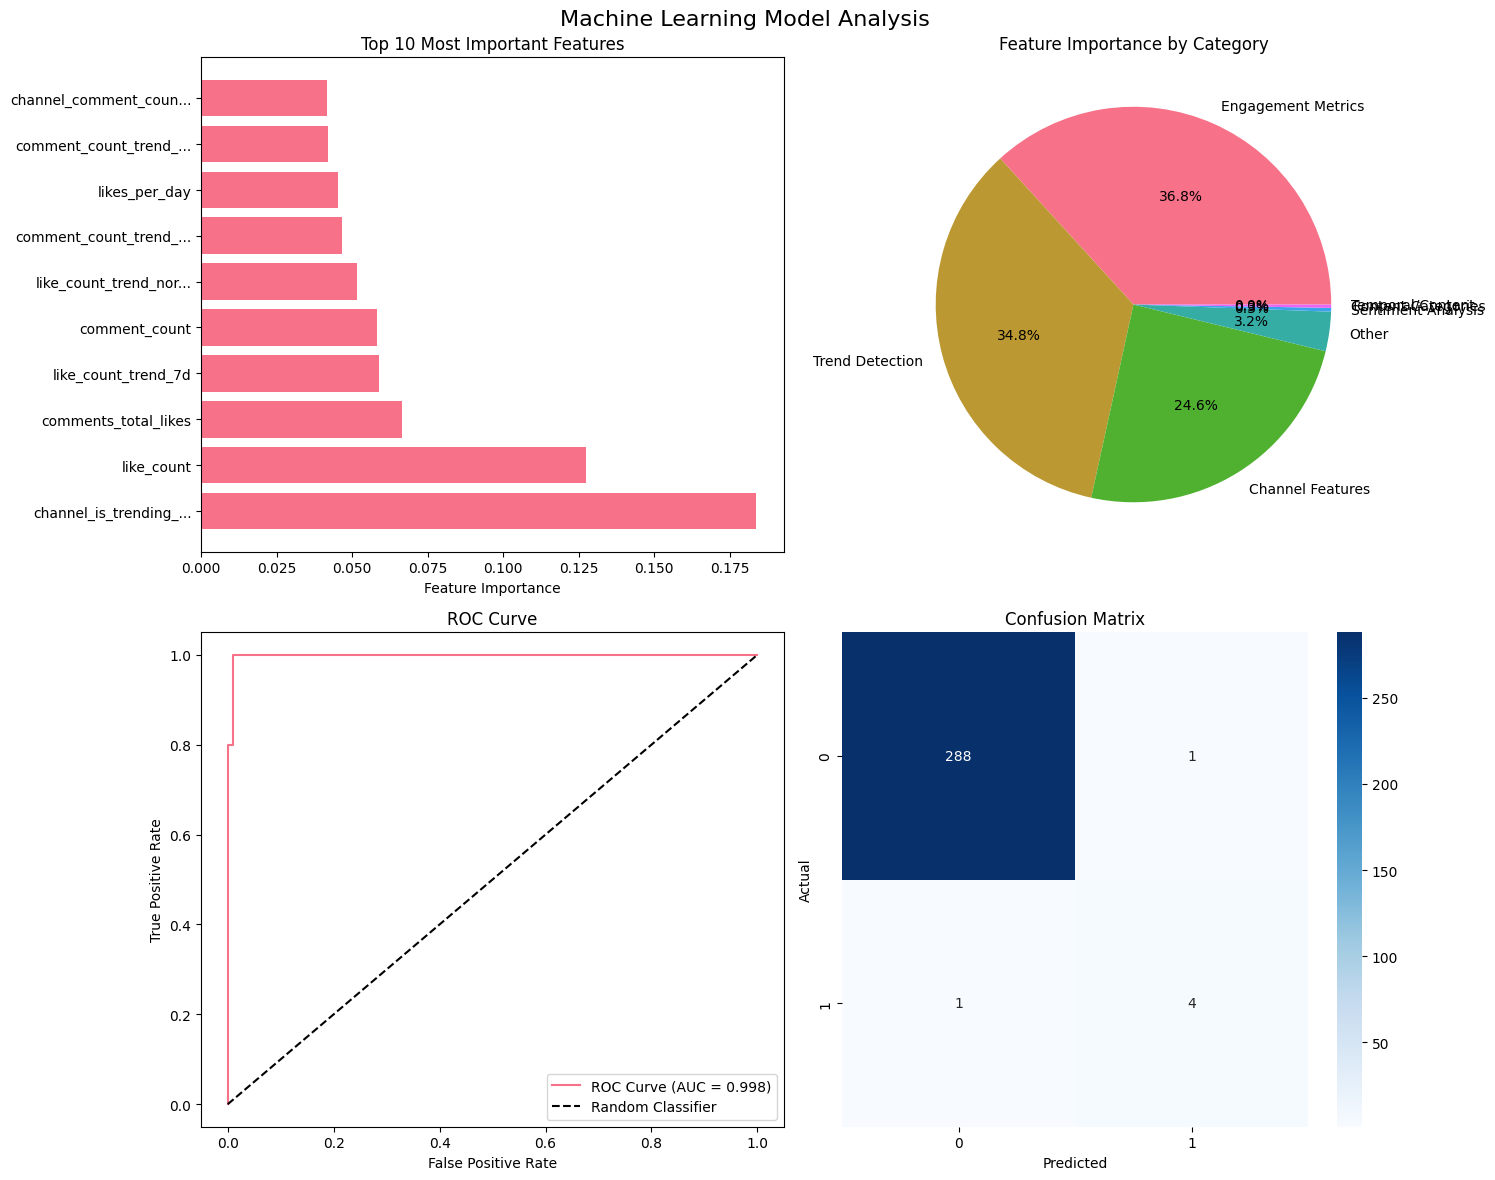

In [134]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Machine Learning Model Analysis', fontsize=16)

# 1. Feature Importance
top_10_features = feature_importance.head(10)
axes[0,0].barh(range(len(top_10_features)), top_10_features['importance'])
axes[0,0].set_yticks(range(len(top_10_features)))
axes[0,0].set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_10_features['feature']])
axes[0,0].set_xlabel('Feature Importance')
axes[0,0].set_title('Top 10 Most Important Features')

# 2. Category Importance
axes[0,1].pie(category_importance.values, labels=category_importance.index, autopct='%1.1f%%')
axes[0,1].set_title('Feature Importance by Category')

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1,0].plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend()

# 4. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')
axes[1,1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

# 9.11 Model Deployment Preparation

In [136]:
# Save model and preprocessing components for deployment
import joblib

# Create model pipeline components
model_components = {
    'model': best_rf,
    'scaler': scaler,
    'feature_selector': selector,
    'selected_features': selected_feature_names,
    'feature_columns': feature_cols,
    'non_feature_columns': non_feature_cols
}

# Save model (uncomment to save)
# joblib.dump(model_components, 'youtube_trending_predictor.pkl')
print("Model components ready for deployment")

print(f"\n✅ Machine Learning Model Development Completed!")
print(f"\n📊 Final Model Summary:")
print(f"- Algorithm: Random Forest with {best_rf.n_estimators} trees")
print(f"- Features used: {len(selected_feature_names)} out of {X.shape[1]} original")
print(f"- Test Accuracy: {test_accuracy:.3f}")
print(f"- Test F1-Score: {test_f1:.3f}")
print(f"- AUC-ROC: {test_auc:.3f}")
print(f"- Most important feature category: {category_importance.index[0]}")
print(f"- Cross-validation stability: ± {cv_scores_detailed['accuracy'].std():.3f}")

Model components ready for deployment

✅ Machine Learning Model Development Completed!

📊 Final Model Summary:
- Algorithm: Random Forest with 300 trees
- Features used: 50 out of 159 original
- Test Accuracy: 0.993
- Test F1-Score: 0.800
- AUC-ROC: 0.998
- Most important feature category: Engagement Metrics
- Cross-validation stability: ± 0.006


# 9.12 Predict time to trend

In [138]:
def train_time_to_trend_model(X_train, y_train_regression):
    """
    Train a model to predict time-to-trend (regression)
    """
    print("Training Time-to-Trend Prediction Model...")
    
    # Create and train regression model
    trend_time_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        random_state=42
    )
    
    trend_time_model.fit(X_train, y_train_regression)
    
    return trend_time_model

# Prepare regression target
if 'estimated_days_to_trend' in df_clean.columns:
    y_regression = df_clean.loc[X_final.index, 'estimated_days_to_trend'].fillna(365)
    
    # Split for regression
    y_reg_train = y_regression.iloc[X_train.index]
    y_reg_test = y_regression.iloc[X_test.index]
    
    # Train time-to-trend model
    time_trend_model = train_time_to_trend_model(X_train, y_reg_train)
    
    # Evaluate
    y_reg_pred = time_trend_model.predict(X_test)
    mae = mean_absolute_error(y_reg_test, y_reg_pred)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
    
    print(f"\n📊 Time-to-Trend Prediction Results:")
    print(f"- Mean Absolute Error: {mae:.1f} days")
    print(f"- Root Mean Squared Error: {rmse:.1f} days")

Training Time-to-Trend Prediction Model...

📊 Time-to-Trend Prediction Results:
- Mean Absolute Error: 0.3 days
- Root Mean Squared Error: 0.9 days


# 10: Model Saving and Export

In [140]:
def save_model_pipeline(models, preprocessors, metadata, output_dir='models'):
    """
    Save all model components for deployment
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare model pipeline
    model_pipeline = {
        'classification_model': models.get('classification'),
        'regression_model': models.get('regression'),
        'lda_model': models.get('lda'),
        'vectorizer': preprocessors.get('vectorizer'),
        'scaler': preprocessors.get('scaler'),
        'feature_selector': preprocessors.get('selector'),
        'label_encoders': preprocessors.get('label_encoders'),
        'metadata': metadata
    }
    
    # Save main pipeline
    pipeline_path = os.path.join(output_dir, 'youtube_trending_pipeline.pkl')
    joblib.dump(model_pipeline, pipeline_path)
    print(f"✅ Model pipeline saved to: {pipeline_path}")
    
    # Save feature importance
    if 'feature_importance' in metadata:
        importance_df = pd.DataFrame(metadata['feature_importance'])
        importance_path = os.path.join(output_dir, 'feature_importance.csv')
        importance_df.to_csv(importance_path, index=False)
        print(f"✅ Feature importance saved to: {importance_path}")
    
    # Save model performance metrics
    metrics_path = os.path.join(output_dir, 'model_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metadata.get('performance_metrics', {}), f, indent=2)
    print(f"✅ Performance metrics saved to: {metrics_path}")
    
    return pipeline_path

# Prepare components for saving
models = {
    'classification': best_rf,
    'regression': time_trend_model if 'time_trend_model' in globals() else None,
    'lda': final_lda if 'final_lda' in globals() else None
}

preprocessors = {
    'vectorizer': vectorizer if 'vectorizer' in globals() else None,
    'scaler': scaler,
    'selector': selector,
    'label_encoders': label_encoders if 'label_encoders' in globals() else {}
}

metadata = {
    'selected_features': selected_feature_names,
    'feature_importance': feature_importance.to_dict('records') if 'feature_importance' in globals() else [],
    'performance_metrics': {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'auc_roc': test_auc,
        'cross_val_f1': cv_scores_detailed['f1'].mean() if 'cv_scores_detailed' in globals() else None
    },
    'topic_labels': topic_labels if 'topic_labels' in globals() else {},
    'training_date': datetime.now().isoformat(),
    'n_training_samples': len(X_train),
    'n_features': len(selected_feature_names)
}

# Save the model pipeline
saved_model_path = save_model_pipeline(models, preprocessors, metadata)

✅ Model pipeline saved to: models\youtube_trending_pipeline.pkl
✅ Feature importance saved to: models\feature_importance.csv
✅ Performance metrics saved to: models\model_metrics.json


# 11: Generate Prediction Report

In [142]:
def generate_analysis_report(df_analysis, model_performance, feature_importance_df, output_path='report.txt'):
    """
    Generate a comprehensive text report of the analysis
    """
    report = []
    report.append("="*80)
    report.append("YOUTUBE SEA FOOD TRAVEL CONTENT - PREDICTIVE ANALYSIS REPORT")
    report.append("="*80)
    report.append(f"\nGenerated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    
    # Executive Summary
    report.append("EXECUTIVE SUMMARY")
    report.append("-"*40)
    report.append(f"• Total Videos Analyzed: {len(df_analysis):,}")
    report.append(f"• Trending Videos: {df_analysis['is_trending'].sum():,} ({df_analysis['is_trending'].mean():.1%})")
    report.append(f"• Model Accuracy: {model_performance.get('accuracy', 0):.1%}")
    report.append(f"• Model F1-Score: {model_performance.get('f1_score', 0):.3f}")
    report.append(f"• Key Success Factor: {feature_importance_df.iloc[0]['feature'] if len(feature_importance_df) > 0 else 'N/A'}\n")
    
    # Content Insights
    report.append("KEY CONTENT INSIGHTS")
    report.append("-"*40)
    
    # Best performing categories
    if 'dominant_topic_label' in df_analysis.columns:
        topic_performance = df_analysis.groupby('dominant_topic_label')['is_trending'].mean().sort_values(ascending=False)
        report.append("\nTop Performing Topics:")
        for topic, rate in topic_performance.head(3).items():
            report.append(f"  • {topic}: {rate:.1%} trending rate")
    
    # Optimal posting patterns
    if 'publish_day_of_week' in df_analysis.columns:
        best_days = df_analysis.groupby('publish_day_of_week')['is_trending'].mean().sort_values(ascending=False)
        day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        report.append("\nOptimal Posting Days:")
        for day_idx in best_days.head(3).index:
            report.append(f"  • {day_names[int(day_idx)]}: {best_days.iloc[day_idx]:.1%} trending rate")
    
    # Feature Importance
    report.append("\nTOP PREDICTIVE FEATURES")
    report.append("-"*40)
    for idx, row in feature_importance_df.head(10).iterrows():
        report.append(f"{idx+1}. {row['feature']}: {row['importance']:.4f}")
    
    # Recommendations
    report.append("\nACTIONABLE RECOMMENDATIONS")
    report.append("-"*40)
    report.append("1. Focus on content themes with highest trending rates")
    report.append("2. Post during optimal days and hours identified")
    report.append("3. Maintain engagement metrics above threshold values")
    report.append("4. Monitor early performance indicators for trend prediction")
    
    # Save report
    report_text = '\n'.join(report)
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(report_text)
    
    print(f"✅ Report saved to: {output_path}")
    print("\nReport Preview:")
    print('\n'.join(report[:20]))  # Show first 20 lines
    
    return report_text

# Generate the report
if 'feature_importance' in globals():
    report = generate_analysis_report(
        df_clean,
        metadata['performance_metrics'],
        feature_importance,
        'analysis_report.txt'
    )

✅ Report saved to: analysis_report.txt

Report Preview:
YOUTUBE SEA FOOD TRAVEL CONTENT - PREDICTIVE ANALYSIS REPORT

Generated on: 2025-09-21 10:22:40

EXECUTIVE SUMMARY
----------------------------------------
• Total Videos Analyzed: 1,466
• Trending Videos: 25 (1.7%)
• Model Accuracy: 99.3%
• Model F1-Score: 0.800
• Key Success Factor: channel_is_trending_mean_x

KEY CONTENT INSIGHTS
----------------------------------------

Top Performing Topics:
  • Street Food: 1.9% trending rate
  • Cooking & Recipes: 0.0% trending rate
  • Topic_2: 0.0% trending rate

Optimal Posting Days:
  • Fri: 1.4% trending rate
  • Tue: 2.1% trending rate


# 12: Prepare Data for User Input Predictions

In [144]:
def create_prediction_function(model_pipeline):
    """
    Create a function that can be used for making predictions on new data
    """
    def predict_trending(video_metadata):
        """
        Predict trending probability for new video metadata
        
        Args:
            video_metadata: Dictionary with video information
            
        Returns:
            Dictionary with predictions and recommendations
        """
        # Extract features from metadata
        features = extract_features_from_metadata(video_metadata)
        
        # Scale features
        features_scaled = model_pipeline['scaler'].transform([features])
        
        # Select features
        features_selected = model_pipeline['feature_selector'].transform(features_scaled)
        
        # Make predictions
        trending_prob = model_pipeline['classification_model'].predict_proba(features_selected)[0, 1]
        trending_pred = model_pipeline['classification_model'].predict(features_selected)[0]
        
        # Time to trend prediction if available
        if model_pipeline.get('regression_model'):
            days_to_trend = model_pipeline['regression_model'].predict(features_selected)[0]
        else:
            days_to_trend = None
        
        return {
            'trending_probability': trending_prob,
            'is_trending_prediction': bool(trending_pred),
            'estimated_days_to_trend': days_to_trend,
            'confidence': trending_prob if trending_pred else 1 - trending_prob,
            'recommendations': generate_recommendations(features, trending_prob)
        }
    
    return predict_trending

def extract_features_from_metadata(metadata):
    """
    Extract features from user-provided metadata
    This would be used by the Streamlit app
    """
    # This is a placeholder - would need to match your feature engineering
    features = []
    # Add feature extraction logic based on metadata
    return features

def generate_recommendations(features, trending_prob):
    """
    Generate actionable recommendations based on prediction
    """
    recommendations = []
    
    if trending_prob < 0.3:
        recommendations.append("Consider optimizing your title for better SEO")
        recommendations.append("Review successful videos in your category for inspiration")
    elif trending_prob < 0.7:
        recommendations.append("Your content shows potential - focus on early engagement")
        recommendations.append("Consider promoting within first 48 hours")
    else:
        recommendations.append("High trending potential detected!")
        recommendations.append("Ensure thumbnail and description are optimized")
    
    return recommendations

# Create the prediction function
if saved_model_path:
    loaded_pipeline = joblib.load(saved_model_path)
    predict_function = create_prediction_function(loaded_pipeline)
    print("✅ Prediction function created for user inputs")


✅ Prediction function created for user inputs
